# SPAN Benchmarks H3K36me3 vs RNA-seq

See https://pubmed.ncbi.nlm.nih.gov/27169896/


In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.auto import tqdm
from itertools import product
import tempfile

In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

# Hg38 H3K36me3 vs RNA-seq quanitified

## Hg38 Load GTF file

In [3]:
gtf_df = pd.read_csv(os.path.expanduser(
    '~/data/2023_Immune/gencode.GRCh38.p13.v41.annotation.gtf'),
    sep='\t', comment='#',
    names=['chromosome', 'db', 'type', 'start', 'end', 'point1', 'strand', 'point2', 'aux'])
gtf_df.sample(10)

chromosome       db         type      start        end point1 strand  \
2103034      chr12   HAVANA  start_codon   76487549   76487551      .      -   
2439220      chr15   HAVANA         gene   77984036   78077724      .      -   
247651        chr1   HAVANA          CDS  184054728  184054863      .      +   
1677886      chr10  ENSEMBL          UTR   31805404   31807660      .      -   
2650106      chr17   HAVANA         exon    7943391    7943599      .      +   
2488772      chr16   HAVANA         exon    2979808    2979936      .      -   
1854601      chr11   HAVANA         exon   47788501   47788611      .      -   
2070762      chr12   HAVANA         exon   55700262   55700393      .      -   
2710617      chr17   HAVANA         exon   41990264   41990382      .      -   
2763726      chr17   HAVANA         exon   63594203   63594279      .      +   

        point2                                                aux  
2103034      0  gene_id "ENSG00000091039.17"; transcript_id "E...  
2439220      .  gene_id "ENSG00000167202.12"; gene_type "prote...  
247651       2  gene_id "ENSG00000198860.14"; transcript_id "E...  
1677886      .  gene_id "ENSG00000165322.18"; transcript_id "E...  
2650106      .  gene_id "ENSG00000170037.14"; transcript_id "E...  
2488772      .  gene_id "ENSG00000127564.17"; transcript_id "E...  
1854601      .  gene_id "ENSG00000030066.14"; transcript_id "E...  
2070762      .  gene_id "ENSG00000135424.19"; transcript_id "E...  
2710617      .  gene_id "ENSG00000168259.17"; transcript_id "E...  
2763726      .  gene_id "ENSG00000136485.16"; transcript_id "E...

In [4]:
import re

print('Parse GTF aux data')
auxes = {}
for i, aux in enumerate(tqdm(gtf_df['aux'])):
    for pair in aux.split(';'):
        kv = pair.strip().split(' ')
        if len(kv) != 2:
            continue
        k, v = kv
        if k not in auxes:
            auxes[k] = vs = []
        else:
            vs = auxes[k]
        vs.append(v.strip('"'))

for k, vs in auxes.items():
    if len(vs) == len(gtf_df):
        gtf_df[k] = vs
    else:
        print(f'Ignoring {k}')
del auxes
gtf_df.drop('aux', axis=1, inplace=True)

# Fix . in gene_id
gtf_df['gene_id'] = [re.sub('\..*', '', id) for id in gtf_df['gene_id']]

Parse GTF aux data


  0%|          | 0/3375759 [00:00<?, ?it/s]

Ignoring hgnc_id
Ignoring havana_gene
Ignoring transcript_id
Ignoring transcript_type
Ignoring transcript_name
Ignoring transcript_support_level
Ignoring tag
Ignoring havana_transcript
Ignoring exon_number
Ignoring exon_id
Ignoring ont
Ignoring protein_id
Ignoring ccdsid
Ignoring artif_dupl


In [5]:
print(f'Total hg38 records {len(gtf_df)}')
print(f'Total hg38 genes {sum(gtf_df["type"] == "gene")}')
print(f'Total hg38 protein_coding genes {sum((gtf_df["type"] == "gene") & (gtf_df["gene_type"] == "protein_coding"))}')

gtf_genes_df = gtf_df[gtf_df['type'] == 'gene']
gtf_genes_df.sample(5)

Total hg38 records 3375759
Total hg38 genes 61852
Total hg38 protein_coding genes 20017


chromosome      db  type      start        end point1 strand point2  \
718016        chr3  HAVANA  gene  130097782  130111506      .      -      .   
1445916       chr8  HAVANA  gene   47202444   47202897      .      -      .   
424774        chr2  HAVANA  gene  102249857  102250255      .      -      .   
193843        chr1  HAVANA  gene  152018662  152022508      .      +      .   
822332        chr4  HAVANA  gene   41872741   41882955      .      -      .   

                 gene_id                           gene_type   gene_name level  
718016   ENSG00000253540  transcribed_unprocessed_pseudogene     FAM86HP     2  
1445916  ENSG00000215177                     IG_V_pseudogene  IGLV8OR8-1     2  
424774   ENSG00000205716                processed_pseudogene    FAM183DP     1  
193843   ENSG00000240667              unprocessed_pseudogene     NBPF18P     2  
822332   ENSG00000245870                              lncRNA   LINC00682     2

## Annotate quanitified RNA-seq with positions

In [6]:
def merge_genes(full_df):
    print('Merging overlapping regions', len(full_df))
    ts = []
    for chr in full_df['chromosome'].unique():
        t = full_df[full_df['chromosome'] == chr].sort_values(by=['start', 'end']).copy()
        cols = t.columns.difference(['start', 'end'])
        grps = t['start'].sub(t['end'].shift()).gt(1).cumsum()
        gpby = t.groupby(grps)
        t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
        t['chromosome'] = chr
        t['gene_id'] = 'merged'
        t['strand'] = '.'
        t = t[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM']]
        ts.append(t)
    ts = pd.concat(ts).reset_index(drop=True)
    print('Reduced to', len(ts))
    return ts

In [7]:
import re

GSE26320_RNASEQ_PATH = os.path.expanduser('~/data/2023_GSE26320_rnaseq')

EXPRESSION_TSV = {
    ('GM12878', 'rep1'): 'GM12878_rep1_RNAseq_hg38_ENCFF723ICA.tsv',
    ('GM12878', 'rep2'): 'GM12878_rep2_RNAseq_hg38_ENCFF418FIT.tsv',
    ('H1', 'rep1'): 'H1_rep1_RNAseq_hg38_ENCFF093NEQ.tsv',
    ('H1', 'rep2'): 'H1_rep1_RNAseq_hg38_ENCFF093NEQ.tsv',
    ('HMEC', 'rep1'): 'HMEC_rep1_RNAseq_hg38_ENCFF292FVY.tsv',
    ('HMEC', 'rep2'): 'HMEC_rep2_RNAseq_hg38_ENCFF219EZH.tsv',
    ('HSMM', 'rep1'): 'HSMM_rep1_RNAseq_hg38_ENCFF551YKI.tsv',
    ('HSMM', 'rep2'): 'HSMM_rep2_RNAseq_hg38_ENCFF497BUG.tsv',
    ('HepG2', 'rep1'): 'HepG2_rep1_RNAseq_hg38_ENCFF773JNC.tsv',
    ('HepG2', 'rep2'): 'HepG2_rep2_RNAseq_hg38_ENCFF570ZOT.tsv',
    ('Huvec', 'rep1'): 'Huvec_rep1_RNAseq_hg38_ENCFF454MTF.tsv',
    ('Huvec', 'rep2'): 'Huvec_rep2_RNAseq_hg38_ENCFF134FYP.tsv',
    ('K562', 'rep1'): 'K562_rep1_RNAseq_hg38_ENCFF139IXQ.tsv',
    ('K562', 'rep2'): 'K562_rep2_RNAseq_hg38_ENCFF088RDE.tsv',
    ('NHEK', 'rep1'): 'NHEK_rep1_RNAseq_hg38_ENCFF004JWA.tsv',
    ('NHEK', 'rep2'): 'NHEK_rep1_RNAseq_hg38_ENCFF004JWA.tsv',
    ('NHLF', 'rep1'): 'NHLF_rep1_RNAseq_hg38_ENCFF577DEC.tsv',
    ('NHLF', 'rep2'): 'NHLF_rep2_RNAseq_hg38_ENCFF412KNK.tsv'
}

EXPRESSION_BED = {}
EXPRESSED_GENES = {}
THRESHOLD = 0.1

for (cell, rep), path in tqdm(EXPRESSION_TSV.items()):
    print(cell, rep, path)
    t = pd.read_csv(GSE26320_RNASEQ_PATH + '/' + path, sep='\t')
    # Fix . in gene_id
    t['gene_id'] = [re.sub('\..*', '', id) for id in t['gene_id']]
    t['LTPM'] = np.log1p(t['TPM'])

    # # Plot expression
    # plt.figure(figsize=(10, 2))
    # ax = plt.axes()
    # g_results = sns.histplot(data=t, x='LTPM', ax=ax,
    #                          stat='density',
    #                          bins=500, kde=True, alpha=0.4)
    # ax.axvline(x=THRESHOLD, color='green')
    # ax.title.set_text(f'{cell} expression')
    # plt.show()

    # Save expressed genes
    full_df = pd.merge(left=t, right=gtf_genes_df, left_on='gene_id', right_on='gene_id')
    full_df = full_df[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM']]

    print(f'Total genes with positions {len(full_df)}')
    full_df = full_df[full_df['LTPM'] > THRESHOLD]
    print(f'Genes logTPM > {THRESHOLD} {len(full_df)}')
    EXPRESSED_GENES[(cell, rep)] = len(full_df)

    # Plot expressed genes lengths
    # plt.figure(figsize=(4, 2))
    # ax = plt.axes()
    # g_results = sns.histplot(x=full_df['end']-full_df['start'], ax=ax,
    #                          stat='density',
    #                          bins=100, log_scale=True, kde=True, alpha=0.4)
    # g_results.set(xscale='log')
    # ax.title.set_text(f'{cell} genes lengths')
    # plt.show()

    expr_path = GSE26320_RNASEQ_PATH + '/' + path.replace('.tsv', f'_tpm{THRESHOLD}.bed')
    full_df.sort_values(by=['chromosome', 'start'], inplace=True)
    full_df = merge_genes(full_df)
    full_df.to_csv(expr_path, sep='\t', index=False, header=None)
    print(f'Saved expressed genes fom {cell} to {expr_path}')
    EXPRESSION_BED[(cell, rep)] = expr_path


  0%|          | 0/18 [00:00<?, ?it/s]

GM12878 rep1 GM12878_rep1_RNAseq_hg38_ENCFF723ICA.tsv
Total genes with positions 58387
Genes logTPM > 0.1 15835
Merging overlapping regions 15835
Reduced to 11828
Saved expressed genes fom GM12878 to /home/jetbrains/data/2023_GSE26320_rnaseq/GM12878_rep1_RNAseq_hg38_ENCFF723ICA_tpm0.1.bed
GM12878 rep2 GM12878_rep2_RNAseq_hg38_ENCFF418FIT.tsv
Total genes with positions 56646
Genes logTPM > 0.1 15750
Merging overlapping regions 15750
Reduced to 11837
Saved expressed genes fom GM12878 to /home/jetbrains/data/2023_GSE26320_rnaseq/GM12878_rep2_RNAseq_hg38_ENCFF418FIT_tpm0.1.bed
H1 rep1 H1_rep1_RNAseq_hg38_ENCFF093NEQ.tsv
Total genes with positions 56646
Genes logTPM > 0.1 19379
Merging overlapping regions 19379
Reduced to 14688
Saved expressed genes fom H1 to /home/jetbrains/data/2023_GSE26320_rnaseq/H1_rep1_RNAseq_hg38_ENCFF093NEQ_tpm0.1.bed
H1 rep2 H1_rep1_RNAseq_hg38_ENCFF093NEQ.tsv
Total genes with positions 56646
Genes logTPM > 0.1 19379
Merging overlapping regions 19379
Reduced to 146

## Hg38 load peaks

In [8]:
GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320')
# GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320_no_control')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
# GSE26320_CELLS = ['H1', 'GM12878', 'K562']
# Ignore
# HMEC rep1 - bad quality overlap for all tools
# HSMM - bad rep1
# H1 and NHLF produce < 100 peaks by MACS2
# Huvec - bad quality track rep1

# GSE26320_CELLS = ['GM12878',  'K562', 'H1']
# GSE26320_MODIFICATIONS = ['CTCF', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K9ac', 'H4K20me1']
GSE26320_MODIFICATIONS = ['H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']


! mkdir -p {GSE26320_PATH_HG38}/pics

In [9]:
def load_peaks_fdr(path, suffix, fdrs):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'fdr', 'peaks', 'avlength'],
                          dtype=object)
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        cell = next((cc for cc in GSE26320_CELLS if cc in f), None)
        mod = next((m for m in GSE26320_MODIFICATIONS if m in f), None)
        rep = next((r for r in GSE26320_REPS if r in f), None)
        if fdr and cell and rep and mod:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (peaks_path, mod, cell, rep, fdr, ps, avls)
    return df_fdr

In [10]:
df_fdr_macs2 = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'macs2'), '.narrowPeak', ['0.05'])
df_fdr_macs2['tool'] = 'MACS2'
print('MACS2', len(df_fdr_macs2))

df_fdr_macs2broad = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'macs2'), '.broadPeak', ['0.1'])
df_fdr_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_fdr_macs2broad))

df_fdr_sicer = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'sicer'), 'summary-FDR', ['0.01'])
# df_fdr_sicer = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'sicer'), 'scoreisland', ['0.01'])
df_fdr_sicer['tool'] = 'SICER'
print('SICER', len(df_fdr_sicer))

df_fdr_span = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'span'), '.peak', ['0.05'])
df_fdr_span['tool'] = 'SPAN'
print('SPAN', len(df_fdr_span))

df_fdr_peaks = pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span])
df_fdr_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 17


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 17


  0%|          | 0/251 [00:00<?, ?it/s]

SICER 17


  0%|          | 0/88 [00:00<?, ?it/s]

SPAN 17


file modification     cell  \
1   /home/jetbrains/data/2023_GSE26320/span/GSM646...     H3K36me3  GM12878   
7   /home/jetbrains/data/2023_GSE26320/span/GSM646...     H3K36me3  GM12878   
10  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...     H3K36me3     HMEC   
13  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K36me3  GM12878   
0   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K36me3     NHEK   

   replicate   fdr  peaks      avlength         tool  
1       rep2  0.05  20369  18201.725367         SPAN  
7       rep1  0.05  19448  18631.864819         SPAN  
10      rep2  0.01  33598   9346.621882        SICER  
13      rep1  0.05   1741    383.344055        MACS2  
0       rep2   0.1  52495   1826.917630  MACS2 broad

In [11]:
df_fdr_peaks[df_fdr_peaks['peaks'] < 1000]

file modification  cell  \
1   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K36me3  HMEC   
8   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K36me3  HSMM   
9   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K36me3    H1   
14  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K36me3  NHLF   
3   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K36me3  NHLF   
7   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K36me3    H1   
14  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K36me3  HMEC   

   replicate   fdr  peaks    avlength         tool  
1       rep1  0.05      0    0.000000        MACS2  
8       rep1  0.05    529  328.682420        MACS2  
9       rep2  0.05      0    0.000000        MACS2  
14      rep1  0.05      3  326.333333        MACS2  
3       rep1   0.1      3  326.333333  MACS2 broad  
7       rep2   0.1      0    0.000000  MACS2 broad  
14      rep1   0.1      0    0.000000  MACS2 broad

In [12]:
# TOOLS_PALETTE = {'MACS2': 'blue', 'MACS2 broad': 'orange', 'SICER': 'green', 'SPAN': 'red', 'Genes': 'brown'}
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER', 'Genes']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

## Peaks number and lengths

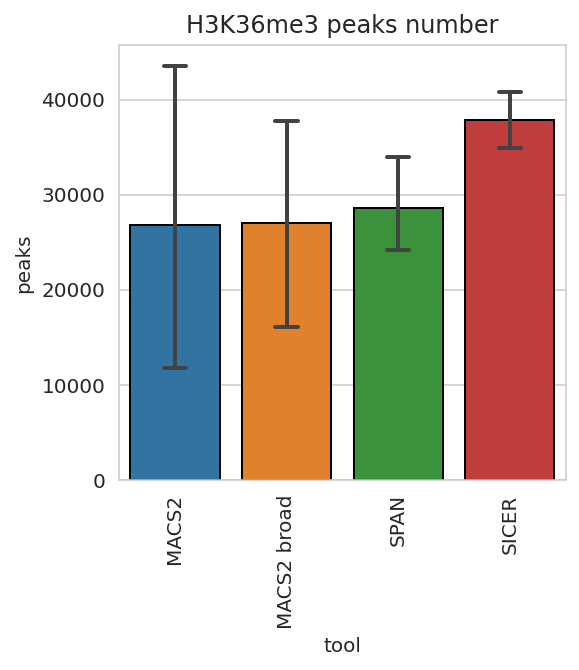

In [13]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_fdr_peaks, x='tool', y='peaks', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('H3K36me3 peaks number')
plt.show()

In [14]:
genes_lengths = []
for (cell, rep), path in tqdm(EXPRESSION_BED.items()):
    t = pd.read_csv(
        path, sep='\t', names=['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'logTPM']
    )
    genes_lengths.extend(t['end'] - t['start'])

  0%|          | 0/18 [00:00<?, ?it/s]

In [15]:
ts = []
ts.append(pd.DataFrame(dict(name=['Genes'] * len(genes_lengths), length=genes_lengths)))
for file, tool in tqdm(zip(df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(name=[tool] * len(lengths), length=lengths))
    ts.append(t.sample(min(len(t), 10_000)))
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

0it [00:00, ?it/s]

name   length
153502        Genes  46556.0
507714        SICER   2599.0
334909        MACS2    466.0
766263         SPAN   2015.0
319213        MACS2    304.0
317626        MACS2    300.0
20313         Genes  68341.0
503386        SICER   5399.0
554479        SICER   2399.0
376916  MACS2 broad   1005.0

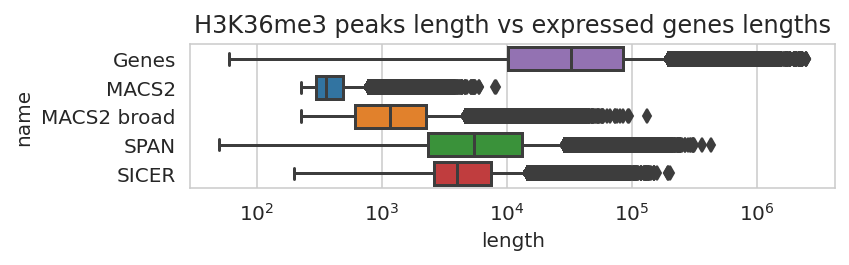

In [16]:
plt.figure(figsize=(6, 2))
ax = plt.axes()
g_results = sns.boxplot(data=t, x='length', y='name', ax=ax,
                        palette=TOOLS_PALETTE,
                        order=['Genes', 'MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
g_results.set(xscale='log')
ax.title.set_text('H3K36me3 peaks length vs expressed genes lengths')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K36me3_lengths.pdf', bbox_inches='tight', dpi=300)
plt.show()

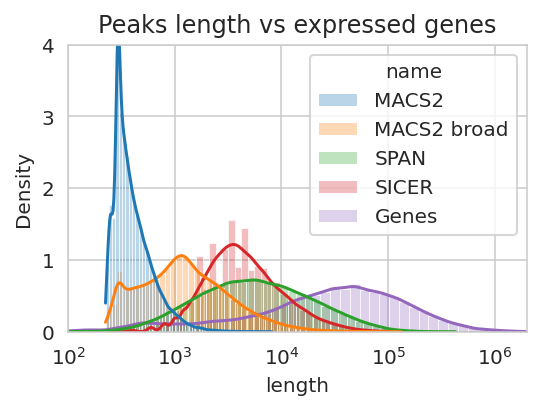

In [17]:
plt.figure(figsize=(4, 3))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='name', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=50, kde=True, log_scale=True, alpha=0.3,
                         palette=TOOLS_PALETTE,
                         hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER', 'Genes'])
g_results.set(xscale='log')
g_results.set_ylim(0, 4)
g_results.set_xlim(1e2, 2e6)
ax.title.set_text('Peaks length vs expressed genes')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K36me3_lengths2.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [18]:
t = []
for file, tool in tqdm(zip(df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    coverage = bedl(file).sum()
    t.append((tool, coverage))
t = pd.DataFrame(data=t, columns=['tool', 'coverage'])
t.sample(3)

0it [00:00, ?it/s]

tool     coverage
21  MACS2 broad   85269094.0
56         SPAN  301994512.0
58         SPAN  362352507.0

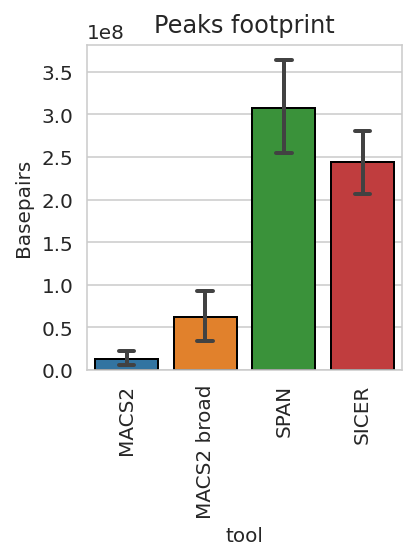

In [19]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
g_results = sns.barplot(data=t, x='tool', y='coverage', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('Peaks footprint')
ax.set_ylabel('Basepairs')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K36me3_sumlength.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Consistency analysis between replicates

In [20]:
reps_overlap = pd.DataFrame(columns=['modification', 'cell', 'tool', 'rep1', 'rep2',
                                     'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
                                     'peaks1_overlap', 'peaks1_overlap_len',
                                     'peaks2_overlap', 'peaks2_overlap_len'], dtype=object)

tf = tempfile.mktemp()

tools = list(sorted(set(df_fdr_peaks['tool'])))
for c, m in tqdm(product(GSE26320_CELLS, GSE26320_MODIFICATIONS)):
    print(c, m)
    tm = df_fdr_peaks[(df_fdr_peaks['cell'] == c) & (df_fdr_peaks['modification'] == m)]
    reps = list(sorted(set(tm['replicate'])))
    for tool in tools:
        for i in range(len(reps)):
            for j in range(i + 1, len(reps)):
                rep1, rep2 = reps[i], reps[j]
                t1 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep1)]
                t2 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep2)]
                if len(t1) == 0 or len(t2) == 0:
                    continue
                file1 = sorted_file(t1['file'].values[0])
                file2 = sorted_file(t2['file'].values[0])
                peaks1 = t1['peaks'].values[0]
                peaks1_len = int(bedl(file1).sum())
                peaks2 = t2['peaks'].values[0]
                peaks2_len = int(bedl(file2).sum())
                !bedtools intersect -a {file1} -b {file2} -wa -u > {tf}
                overlap1 = lines(tf)
                !bedtools intersect -b {file1} -a {file2} -wa -u > {tf}
                overlap2 = lines(tf)
                !bedtools intersect -a {file1} -b {file2} -wo > {tf}
                overlap1_len = overlap2_len = int(last_col(tf).sum())

                reps_overlap.loc[len(reps_overlap)] = \
                    (m, c, tool, rep1, rep2, peaks1, peaks1_len, peaks2, peaks2_len,
                     overlap1, overlap1_len, overlap2, overlap2_len)
reps_overlap.sample(2)

0it [00:00, ?it/s]

GM12878 H3K36me3
HMEC H3K36me3
HSMM H3K36me3
K562 H3K36me3
NHEK H3K36me3
NHLF H3K36me3
H1 H3K36me3
Huvec H3K36me3
HepG2 H3K36me3


modification  cell   tool  rep1  rep2  peaks1  peaks1_len  peaks2  \
12     H3K36me3  K562  MACS2  rep1  rep2   67417    26091123   12897   
8      H3K36me3  HSMM  MACS2  rep1  rep2     529      173873   12203   

    peaks2_len  peaks1_overlap  peaks1_overlap_len  peaks2_overlap  \
12     5543136            8296             2541578            7937   
8      4385962             209               53021             214   

    peaks2_overlap_len  
12             2541578  
8                53021

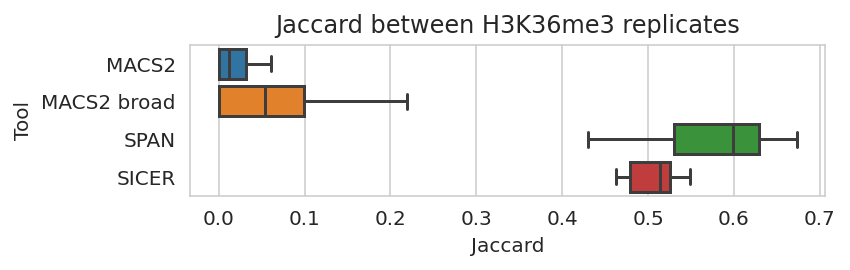

In [21]:
reps_overlap['jaccard'] = [
    d(lo, l1 + l2 - lo)
    for l1, l2, lo in zip(reps_overlap['peaks1_len'], reps_overlap['peaks2_len'], reps_overlap['peaks1_overlap_len'])
]

plt.figure(figsize=(6, 2))

g_result = sns.boxplot(data=reps_overlap, y='tool', x='jaccard', palette=TOOLS_PALETTE, showfliers=False,
                       order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
ax = g_result.axes
ax.set_title('Jaccard between H3K36me3 replicates')
ax.set_xlabel('Jaccard')
ax.set_ylabel('Tool')

plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K36me3_replicates.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [22]:
reps_overlap['peak1_overlap_fraction'] = [d(x, y) for x, y in
                                          zip(reps_overlap['peaks1_overlap'], reps_overlap['peaks1'])]
reps_overlap['peak2_overlap_fraction'] = [d(x, y) for x, y in
                                          zip(reps_overlap['peaks2_overlap'], reps_overlap['peaks2'])]

reps_overlap['peak1_overlap_fraction_len'] = [
    d(x, y) for x, y in zip(reps_overlap['peaks1_overlap_len'], reps_overlap['peaks1_len'])
]
reps_overlap['peak2_overlap_fraction_len'] = [
    d(x, y) for x, y in zip(reps_overlap['peaks2_overlap_len'], reps_overlap['peaks2_len'])
]

reps_overlap.sample(2)

modification   cell   tool  rep1  rep2  peaks1  peaks1_len  peaks2  \
24     H3K36me3  Huvec  MACS2  rep1  rep2   32102    15134306    3389   
16     H3K36me3   NHLF  MACS2  rep1  rep2       3         979  102587   

    peaks2_len  peaks1_overlap  peaks1_overlap_len  peaks2_overlap  \
24     1380886             799              198384             795   
16    56430656               0                   0               0   

    peaks2_overlap_len   jaccard  peak1_overlap_fraction  \
24              198384  0.012158                0.024889   
16                   0  0.000000                0.000000   

    peak2_overlap_fraction  peak1_overlap_fraction_len  \
24                0.234582                    0.013108   
16                0.000000                    0.000000   

    peak2_overlap_fraction_len  
24                    0.143664  
16                    0.000000

In [23]:
t = pd.concat([
    reps_overlap[
        ['modification', 'cell', 'tool', 'peak1_overlap_fraction', 'peak1_overlap_fraction_len']
    ].copy().rename(dict(peak1_overlap_fraction='overlap', peak1_overlap_fraction_len='overlap_len'), axis=1),
    reps_overlap[
        ['modification', 'cell', 'tool', 'peak2_overlap_fraction', 'peak2_overlap_fraction_len']
    ].copy().rename(dict(peak2_overlap_fraction='overlap', peak2_overlap_fraction_len='overlap_len'), axis=1)
]).reset_index(drop=True)
# t

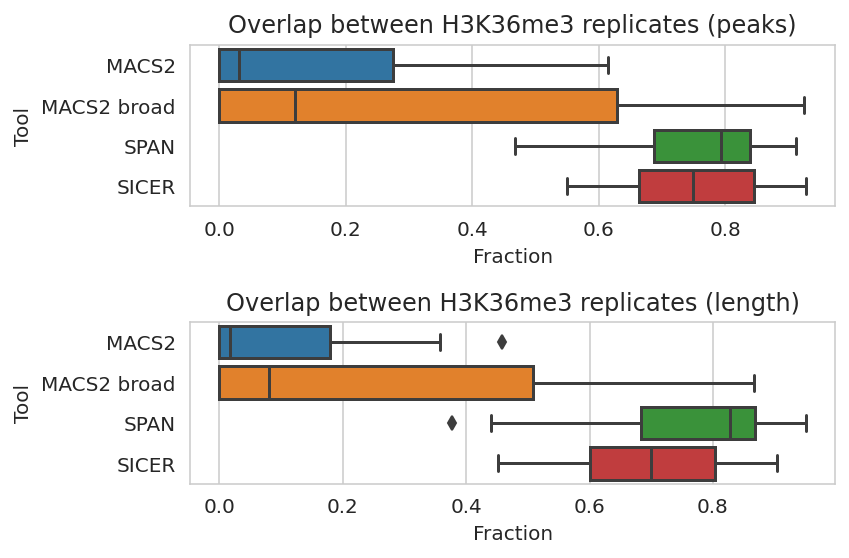

In [24]:
plt.figure(figsize=(6, 4))
axs = [plt.subplot(2, 1, i + 1) for i in range(2)]

g_result = sns.boxplot(data=t, y='tool', x='overlap', ax=axs[0], palette=TOOLS_PALETTE,
                       order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
ax = g_result.axes
ax.set_title('Overlap between H3K36me3 replicates (peaks)')
ax.set_xlabel('Fraction')
ax.set_ylabel('Tool')

g_result = sns.boxplot(data=t, y='tool', x='overlap_len', ax=axs[1], palette=TOOLS_PALETTE,
                       order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
ax = g_result.axes
ax.set_title('Overlap between H3K36me3 replicates (length)')
ax.set_xlabel('Fraction')
ax.set_ylabel('Tool')

plt.tight_layout()
plt.show()

## Overlap H3K36me3 vs expressed genes

In [25]:
import tempfile
from itertools import product

tf = tempfile.mktemp()

bench_df = pd.DataFrame(
    columns=['cell', 'replicate', 'name',
             'peaks', 'peaks_len', 'genes', 'genes_len',
             'peaks_overlap', 'peaks_overlap_len', 'genes_overlap', 'genes_overlap_len'],
    dtype=object
)

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    if (c, r) not in EXPRESSION_BED:
        continue
    expr_file = sorted_file(EXPRESSION_BED[c, r])
    genes = lines(expr_file)
    genes_len = int(bedl(expr_file).sum())
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        peaks_len = int(bedl(peaks_file).sum())
        !bedtools intersect -a {peaks_file} -b {expr_file} -wa -u > {tf}
        peaks_overlap = lines(tf)
        !bedtools intersect -b {peaks_file} -a {expr_file} -wa -u > {tf}
        genes_overlap = lines(tf)
        !bedtools intersect -a {peaks_file} -b {expr_file} -wo > {tf}
        peaks_overlap_len = genes_overlap_len = int(last_col(tf).sum())

        bench_df.loc[len(bench_df)] = (c, r, tool, peaks, peaks_len, genes, genes_len,
                                       peaks_overlap, peaks_overlap_len, genes_overlap, genes_overlap_len)
# bench_df

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


In [26]:
bench_df['precision'] = [d(a, b) for a, b in zip(bench_df['peaks_overlap'], bench_df['peaks'])]
bench_df['sensitivity'] = [d(a, b) for a, b in zip(bench_df['genes_overlap'], bench_df['genes'])]
bench_df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                  for s, p in zip(bench_df['sensitivity'], bench_df['precision'])]

bench_df['precision_len'] = [d(a, b) for a, b in zip(bench_df['peaks_overlap_len'], bench_df['peaks_len'])]
bench_df['sensitivity_len'] = [d(a, b) for a, b in zip(bench_df['genes_overlap_len'], bench_df['genes_len'])]
bench_df['f1_len'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                      for s, p in zip(bench_df['sensitivity_len'], bench_df['precision_len'])]

bench_df['jaccard'] = [
    d(o, p + g - o)
    for p, g, o in zip(bench_df['peaks_len'], bench_df['genes_len'], bench_df['genes_overlap_len'])
]

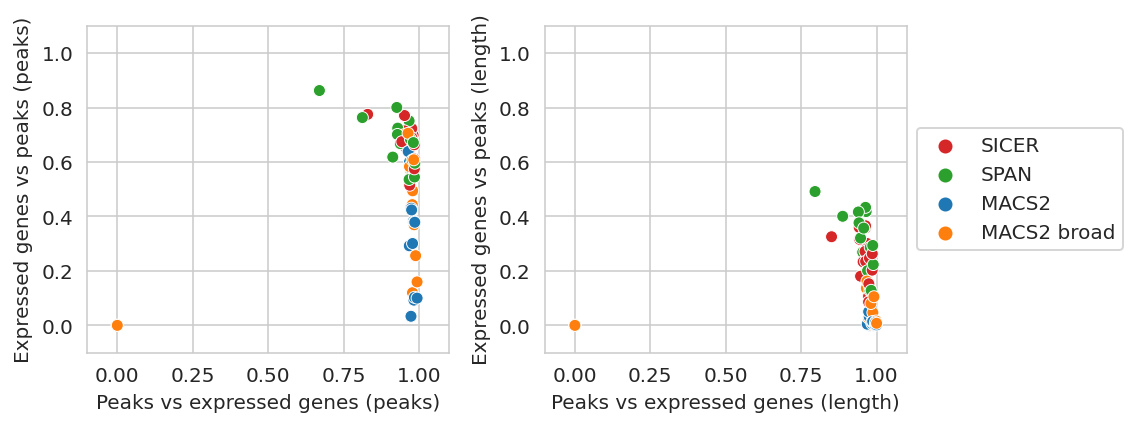

In [27]:
import seaborn as sns

plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

ax = axs[0]
g_results = sns.scatterplot(data=bench_df, x='precision', y='sensitivity', hue='name',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.set_xlabel('Peaks vs expressed genes (peaks)')
g_results.axes.set_ylabel('Expressed genes vs peaks (peaks)')
g_results.axes.set_xlim([-0.1, 1.1])
g_results.axes.set_ylim([-0.1, 1.1])
ax.legend().set_visible(False)

ax = axs[1]
g_results = sns.scatterplot(data=bench_df, x='precision_len', y='sensitivity_len', hue='name',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.set_xlabel('Peaks vs expressed genes (length)')
g_results.axes.set_ylabel('Expressed genes vs peaks (length)')
g_results.axes.set_xlim([-0.1, 1.1])
g_results.axes.set_ylim([-0.1, 1.1])
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [28]:
ts = []
for name in bench_df['name'].unique():
    tn = bench_df[bench_df['name'] == name]
    for variable in ['sensitivity', 'precision', 'f1']:
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['peak'] * len(tn),
                                    value=tn[variable])))
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['length'] * len(tn),
                                    value=tn[f'{variable}_len'])))

t = pd.concat(ts).reset_index(drop=True)
del ts

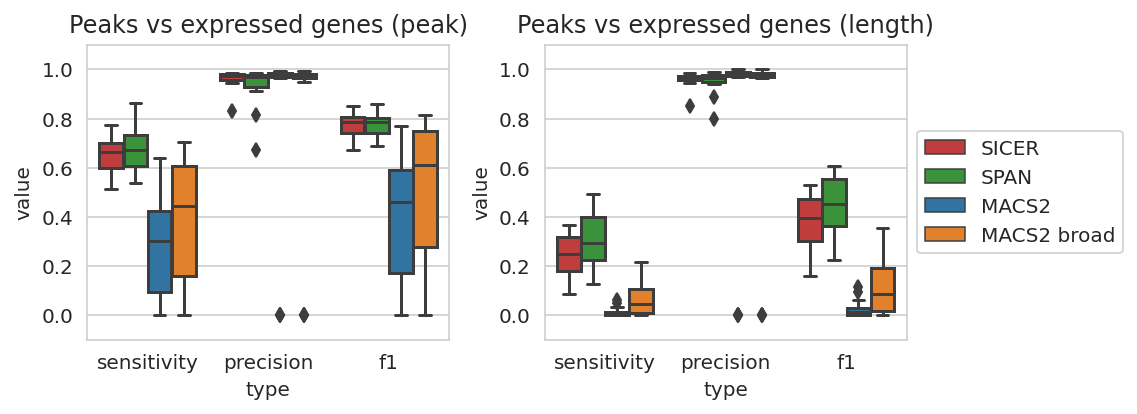

In [29]:
plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, benchmark in enumerate(['peak', 'length']):
    g_results = sns.boxplot(data=t[t['benchmark'] == benchmark], x='type', y='value', hue='name',
                            palette=TOOLS_PALETTE,
                            ax=axs[i])
    ax = g_results.axes
    ax.set_title(f'Peaks vs expressed genes ({benchmark})')
    # Put a legend to the right of the current axis
    if i == 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    ax.set_ylim([-0.1, 1.1])

plt.tight_layout()
plt.show()

## Overlap H3K36me3 diff vs expressed genes

In [30]:
TOOLS = list(sorted(set(bench_df['name'])))

diff_bench_df = pd.DataFrame(
    columns=['cell', 'replicate', 'name',
             'peaks', 'peaks_len',
             'genes', 'genes_len',
             'peaks_overlap', 'peaks_overlap_len',
             'genes_overlap', 'genes_overlap_len'],
    dtype=object
)

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    if (c, r) not in EXPRESSION_BED:
        continue
    print(c, r)
    expr_file = sorted_file(EXPRESSION_BED[(c, r)])
    t = df_fdr_peaks[(df_fdr_peaks['tool'] == 'SPAN') & (df_fdr_peaks['modification'] == 'H3K36me3') &
                     (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
    if len(t) == 0:
        continue
    span_file = sorted_file(t['file'].values[0])
    genes = lines(expr_file)
    genes_len = int(bedl(expr_file).sum())
    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            peaks_len = int(bedl(tf).sum())
            !bedtools intersect -a {tf} -b {expr_file} -wa -u > {tf2}
            peaks_overlap = lines(tf2)
            !bedtools intersect -b {tf} -a {expr_file} -wa -u > {tf2}
            genes_overlap = lines(tf2)
            !bedtools intersect -a {tf} -b {expr_file} -wo > {tf2}
            peaks_overlap_len = genes_overlap_len = int(last_col(tf2).sum())

            diff_bench_df.loc[len(diff_bench_df)] = \
                (c, r, name,
                 peaks, peaks_len,
                 genes, genes_len,
                 peaks_overlap, peaks_overlap_len,
                 genes_overlap, genes_overlap_len)

display(diff_bench_df.sample())

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


cell replicate                name  peaks  peaks_len  genes   genes_len  \
75   H1      rep2  MACS2 broad - SPAN      0          0  14688  1193722902   

    peaks_overlap  peaks_overlap_len  genes_overlap  genes_overlap_len  
75              0                  0              0                  0

In [31]:
diff_bench_df['precision'] = [d(a, b) for a, b in zip(diff_bench_df['peaks_overlap'], diff_bench_df['peaks'])]
diff_bench_df['sensitivity'] = [d(a, b) for a, b in zip(diff_bench_df['genes_overlap'], diff_bench_df['genes'])]
diff_bench_df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                       for s, p in zip(diff_bench_df['sensitivity'], diff_bench_df['precision'])]

diff_bench_df['precision_len'] = [d(a, b) for a, b in
                                  zip(diff_bench_df['peaks_overlap_len'], diff_bench_df['peaks_len'])]
diff_bench_df['sensitivity_len'] = [d(a, b) for a, b in
                                    zip(diff_bench_df['genes_overlap_len'], diff_bench_df['genes_len'])]
diff_bench_df['f1_len'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                           for s, p in zip(diff_bench_df['sensitivity_len'], diff_bench_df['precision_len'])]

diff_bench_df['jaccard'] = [d(o, p + g - o)
                            for p, g, o in zip(diff_bench_df['peaks_len'], diff_bench_df['genes_len'],
                                               diff_bench_df['genes_overlap_len'])
                            ]

In [32]:
full_bench_df = pd.concat([bench_df, diff_bench_df]).reset_index(drop=True)
full_bench_df.sample(5)

cell replicate                name  peaks  peaks_len  genes   genes_len  \
56   Huvec      rep2               SICER  31178  260866422  14173  1032072987   
37    NHLF      rep1                SPAN  27135  488712238  13164  1083212317   
18    HSMM      rep1               MACS2    529     173873  11613   953642362   
43    NHLF      rep2         MACS2 broad  57846  183772341  13420  1093581346   
101   HSMM      rep2  MACS2 broad - SPAN      0          0  11591   951483612   

     peaks_overlap  peaks_overlap_len  genes_overlap  genes_overlap_len  \
56           30698          254758303           8147          254758303   
37           22044          433873634          10044          433873634   
18             515             169830            388             169830   
43           55757          177959066           9465          177959066   
101              0                  0              0                  0   

     precision  sensitivity            f1  precision_len  sensitivity_len  \
56    0.984605     0.574825  7.258751e-01       0.976585         0.246841   
37    0.812383     0.762990  7.869120e-01       0.887790         0.400543   
18    0.973535     0.033411  6.460450e-02       0.976747         0.000178   
43    0.963887     0.705291  8.145573e-01       0.968367         0.162731   
101   0.000000     0.000000  1.000000e-10       0.000000         0.000000   

           f1_len   jaccard  
56   3.940762e-01  0.245389  
37   5.520286e-01  0.381243  
18   3.561065e-04  0.000178  
43   2.786371e-01  0.161870  
101  1.000000e-10  0.000000

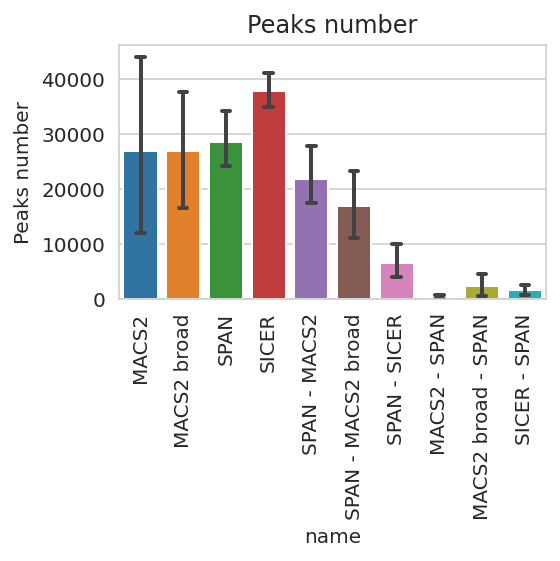

In [33]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Peaks number')
g_results = sns.barplot(data=full_bench_df, x='name', y='peaks',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ]
                        )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Peaks number')
plt.tight_layout()
plt.show()

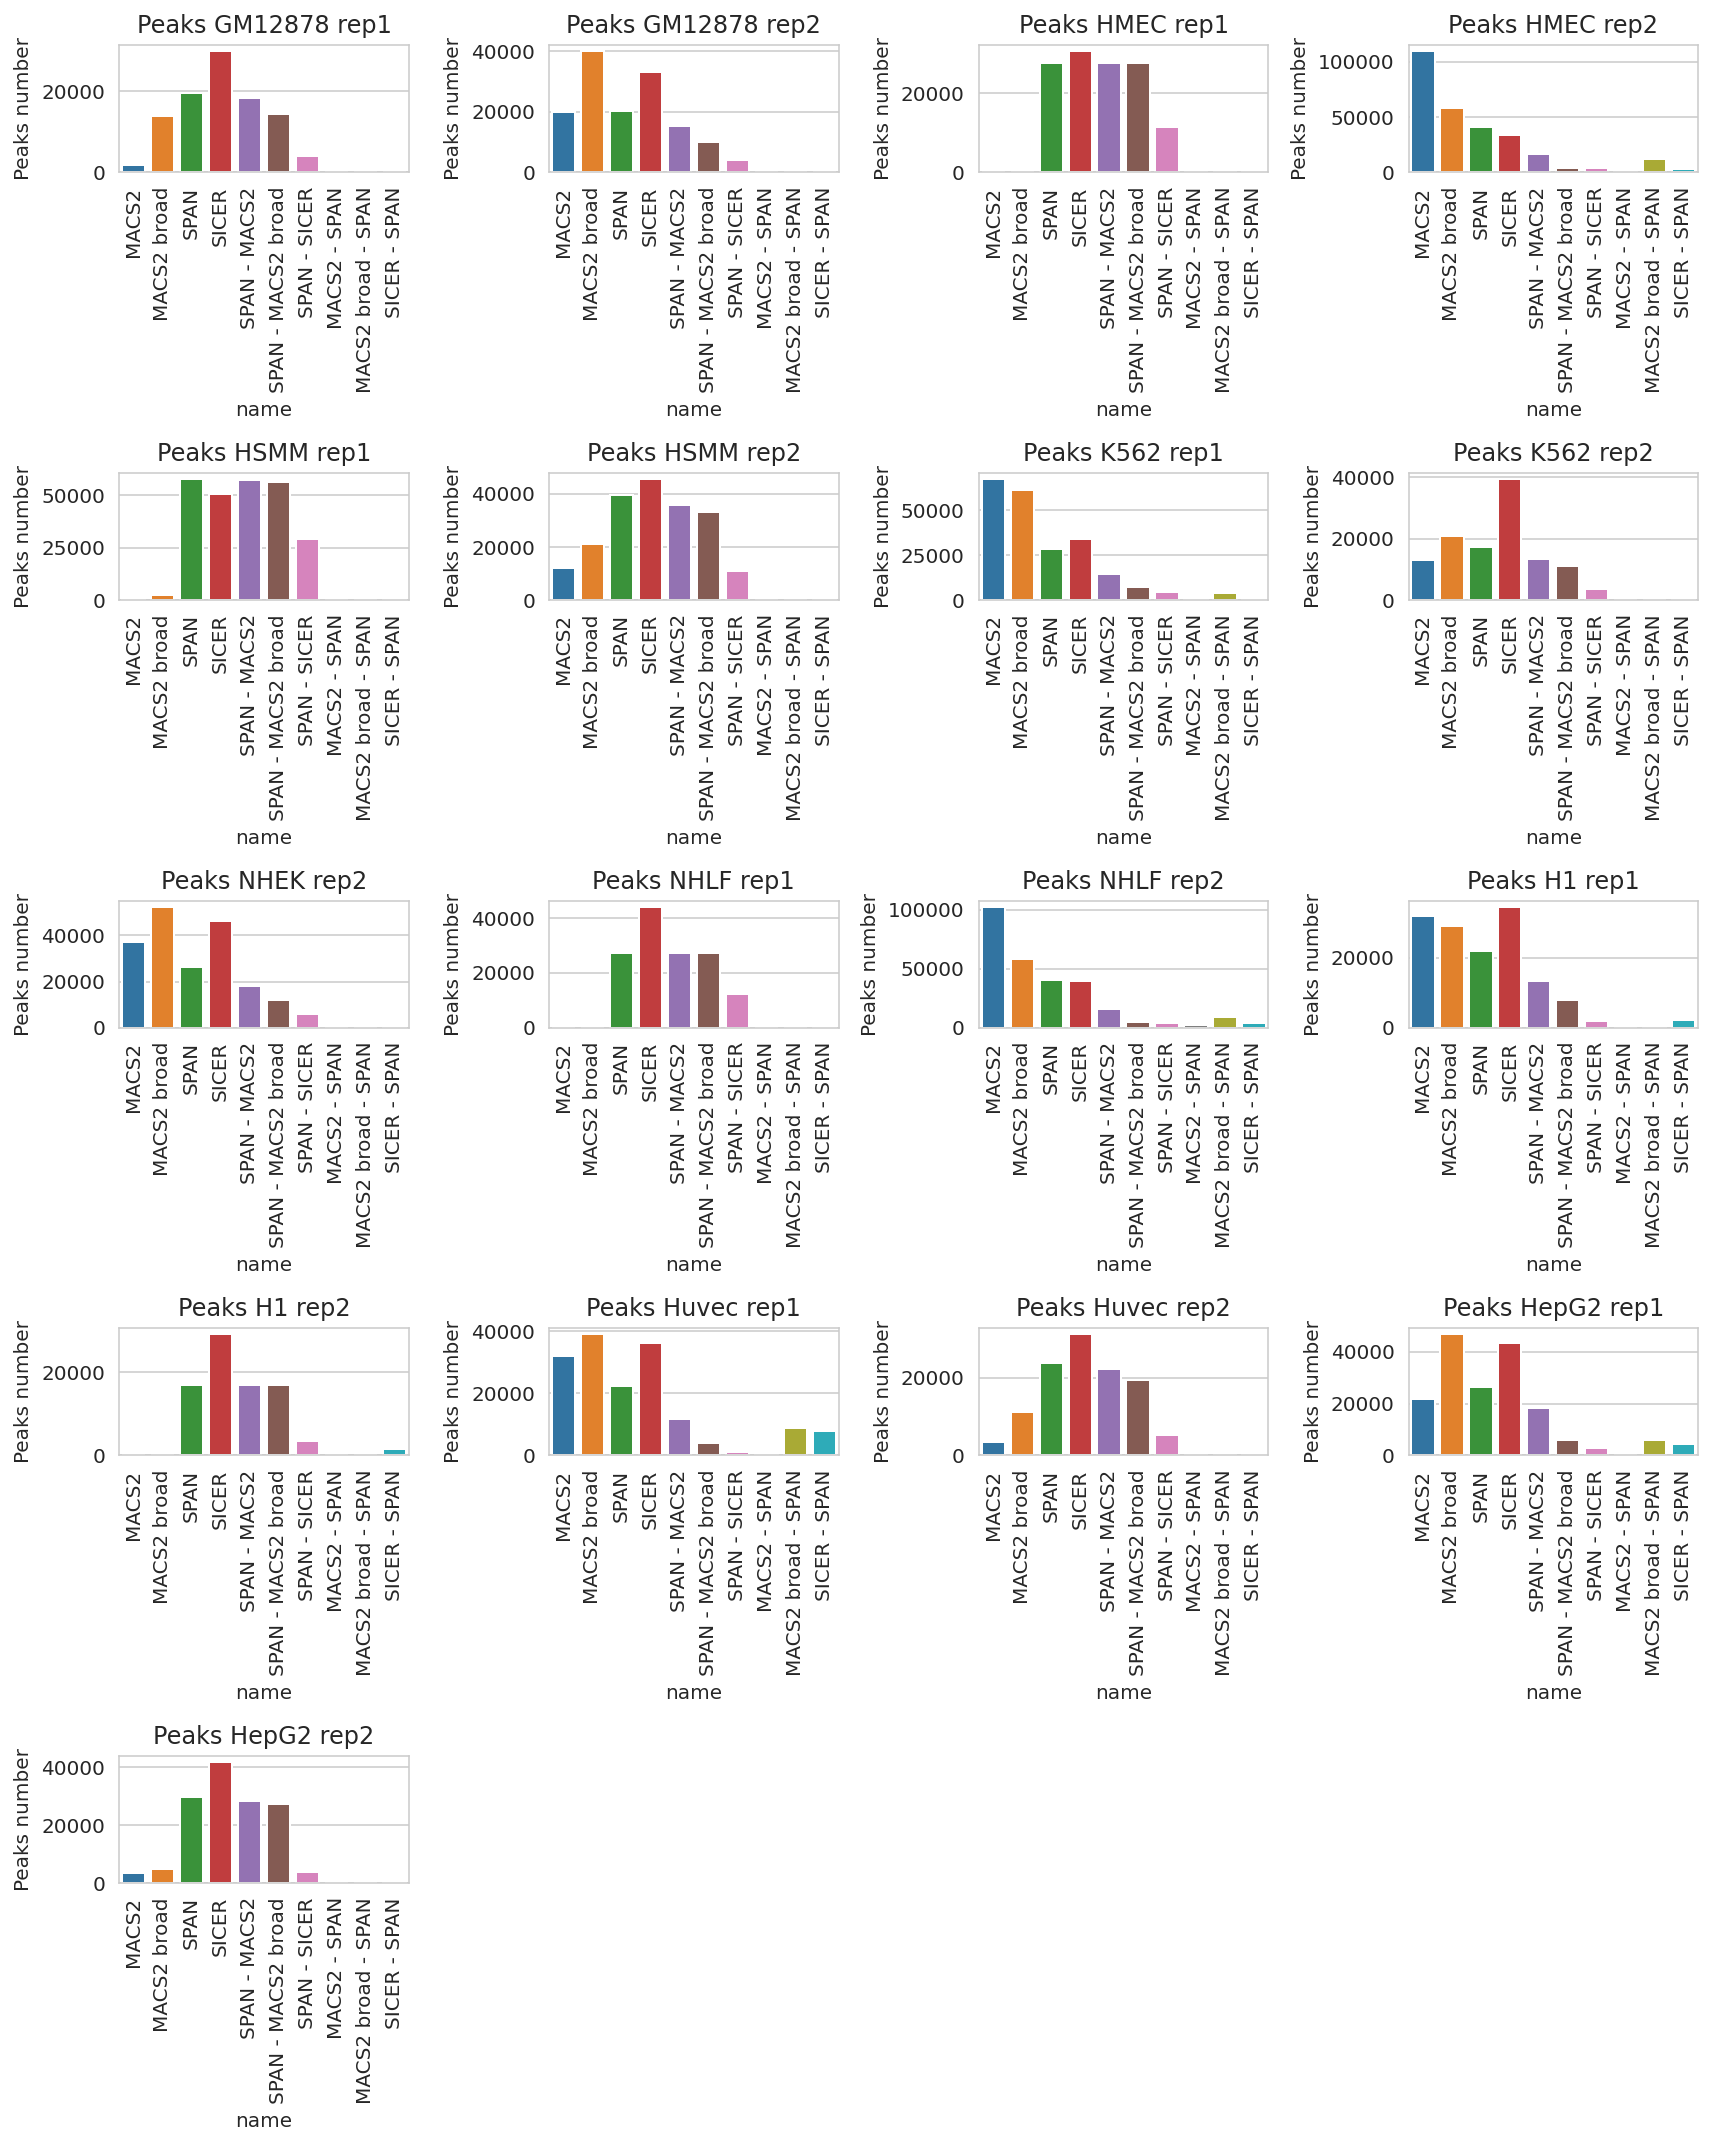

In [34]:
import math
experiments = [(c, r) for c, r in product(GSE26320_CELLS, GSE26320_REPS)
               if sum((full_bench_df['cell'] == c) & (full_bench_df['replicate'] == r)) > 0]

nrows = int(math.ceil(math.sqrt(len(experiments))))
ncols = int(math.ceil(len(experiments) / nrows))
plt.figure(figsize=(3 * ncols, 3 * nrows))
axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(experiments))]
for i, (c, r) in enumerate(experiments):
    ax = axs[i]
    ax.title.set_text(f'Peaks {c} {r}')
    g_results = sns.barplot(data=full_bench_df[(full_bench_df['cell'] == c) & (full_bench_df['replicate']==r)],
                        x='name', y='peaks',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ]
                        )
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Peaks number')
plt.tight_layout()
plt.show()

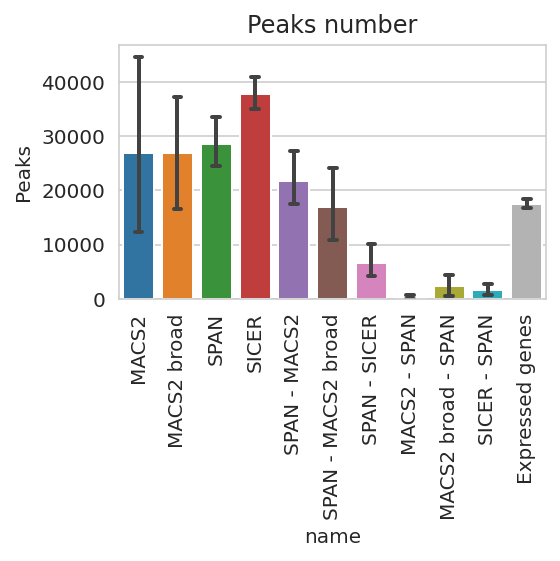

In [35]:
t = full_bench_df[['cell', 'replicate', 'name', 'peaks']].copy()
for cell, rep in EXPRESSED_GENES.keys():
    t.loc[len(t)] = (cell, rep, 'Expressed genes', EXPRESSED_GENES[(cell, rep)])


palette = plt.cm.get_cmap('tab10')

TOOLS_GENES_PALETTE = {t: palette(i) for i, t in enumerate(
    ['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
     'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
     'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN']
)}
TOOLS_GENES_PALETTE['Expressed genes'] = (0.7, 0.7, 0.7, 1.0)

plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Peaks number')
ax.xaxis.set_tick_params(rotation=90)
g_results = sns.barplot(data=t,
                        x='name', y='peaks',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               'Expressed genes'
                               ],
                        palette=TOOLS_GENES_PALETTE
                        )
ax.set_ylabel('Peaks')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K36me3_peaks.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Save benchmark df

In [36]:
full_bench_df.to_csv(GSE26320_PATH_HG38 + '/H3K36me3_full_bench_df.csv.gz', index=False, compression='gzip')

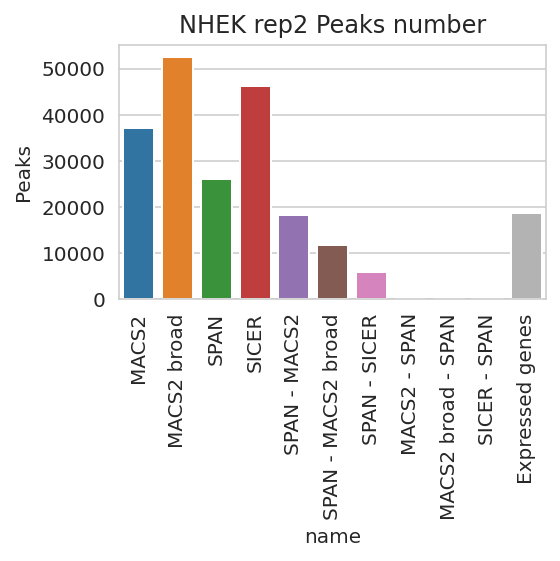

In [37]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('NHEK rep2 Peaks number')
g_results = sns.barplot(data=t[(t['cell']=='NHEK') & (t['replicate'] == 'rep2')],
                        x='name', y='peaks',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               'Expressed genes'
                               ],
                        palette=TOOLS_GENES_PALETTE
                        )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Peaks')
plt.tight_layout()
plt.show()

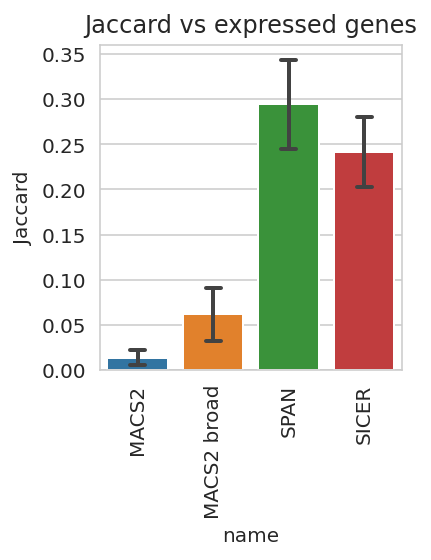

In [38]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
ax.title.set_text('Jaccard vs expressed genes')
g_results = sns.barplot(data=full_bench_df, x='name', y='jaccard',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
                        )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Jaccard')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K36me3_jaccard_vs_genes.pdf', bbox_inches='tight', dpi=300)
plt.show()

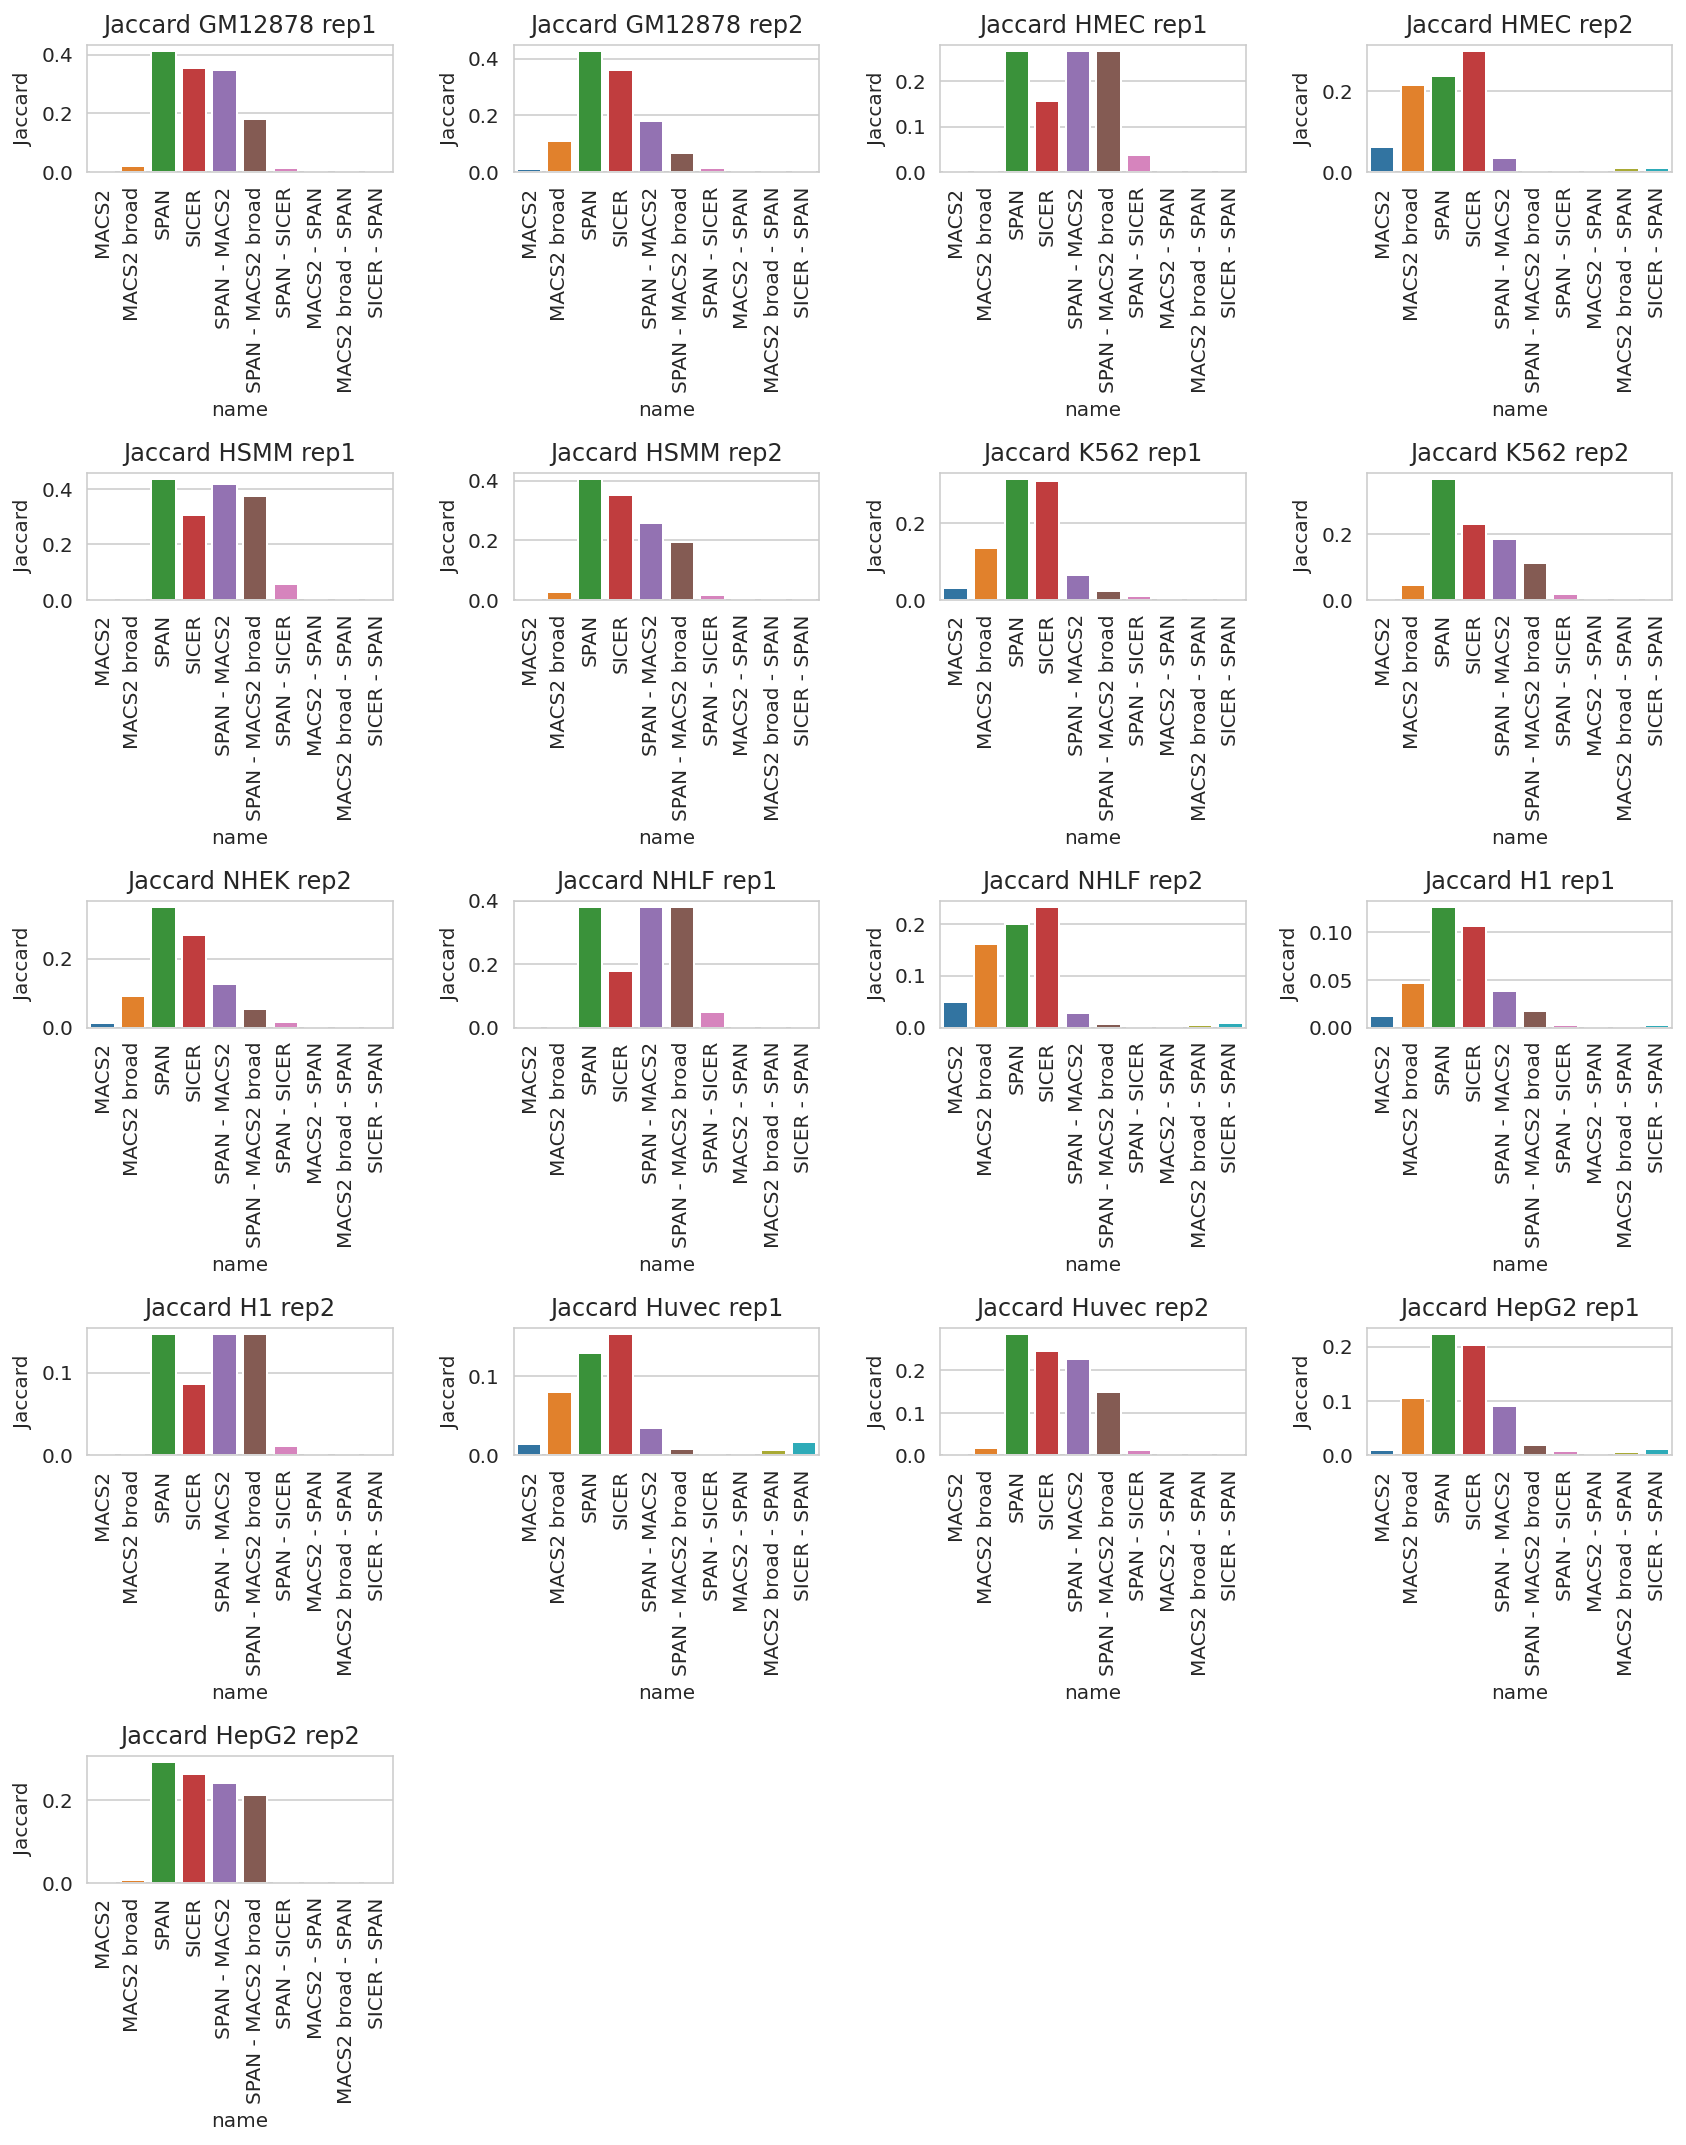

In [39]:
import math
experiments = [(c, r) for c, r in product(GSE26320_CELLS, GSE26320_REPS)
               if sum((full_bench_df['cell'] == c) & (full_bench_df['replicate'] == r)) > 0]

nrows = int(math.ceil(math.sqrt(len(experiments))))
ncols = int(math.ceil(len(experiments) / nrows))
plt.figure(figsize=(3 * ncols, 3 * nrows))
axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(experiments))]
for i, (c, r) in enumerate(experiments):
    ax = axs[i]
    ax.title.set_text(f'Jaccard {c} {r}')
    g_results = sns.barplot(data=full_bench_df[(full_bench_df['cell'] == c) & (full_bench_df['replicate']==r)],
                            x='name', y='jaccard',
                            ax=ax,
                            capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   ]
                            )
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Jaccard')
plt.tight_layout()
plt.show()

In [40]:
ts = []
for name in full_bench_df['name'].unique():
    tn = full_bench_df[full_bench_df['name'] == name]
    for variable in ['sensitivity', 'precision', 'f1']:
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['peaks'] * len(tn),
                                    value=tn[variable],
                                    cell=tn['cell'],
                                    replicate=tn['replicate'])))
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['length'] * len(tn),
                                    value=tn[f'{variable}_len'],
                                    cell=tn['cell'],
                                    replicate=tn['replicate'])))
t = pd.concat(ts).reset_index(drop=True)
del ts

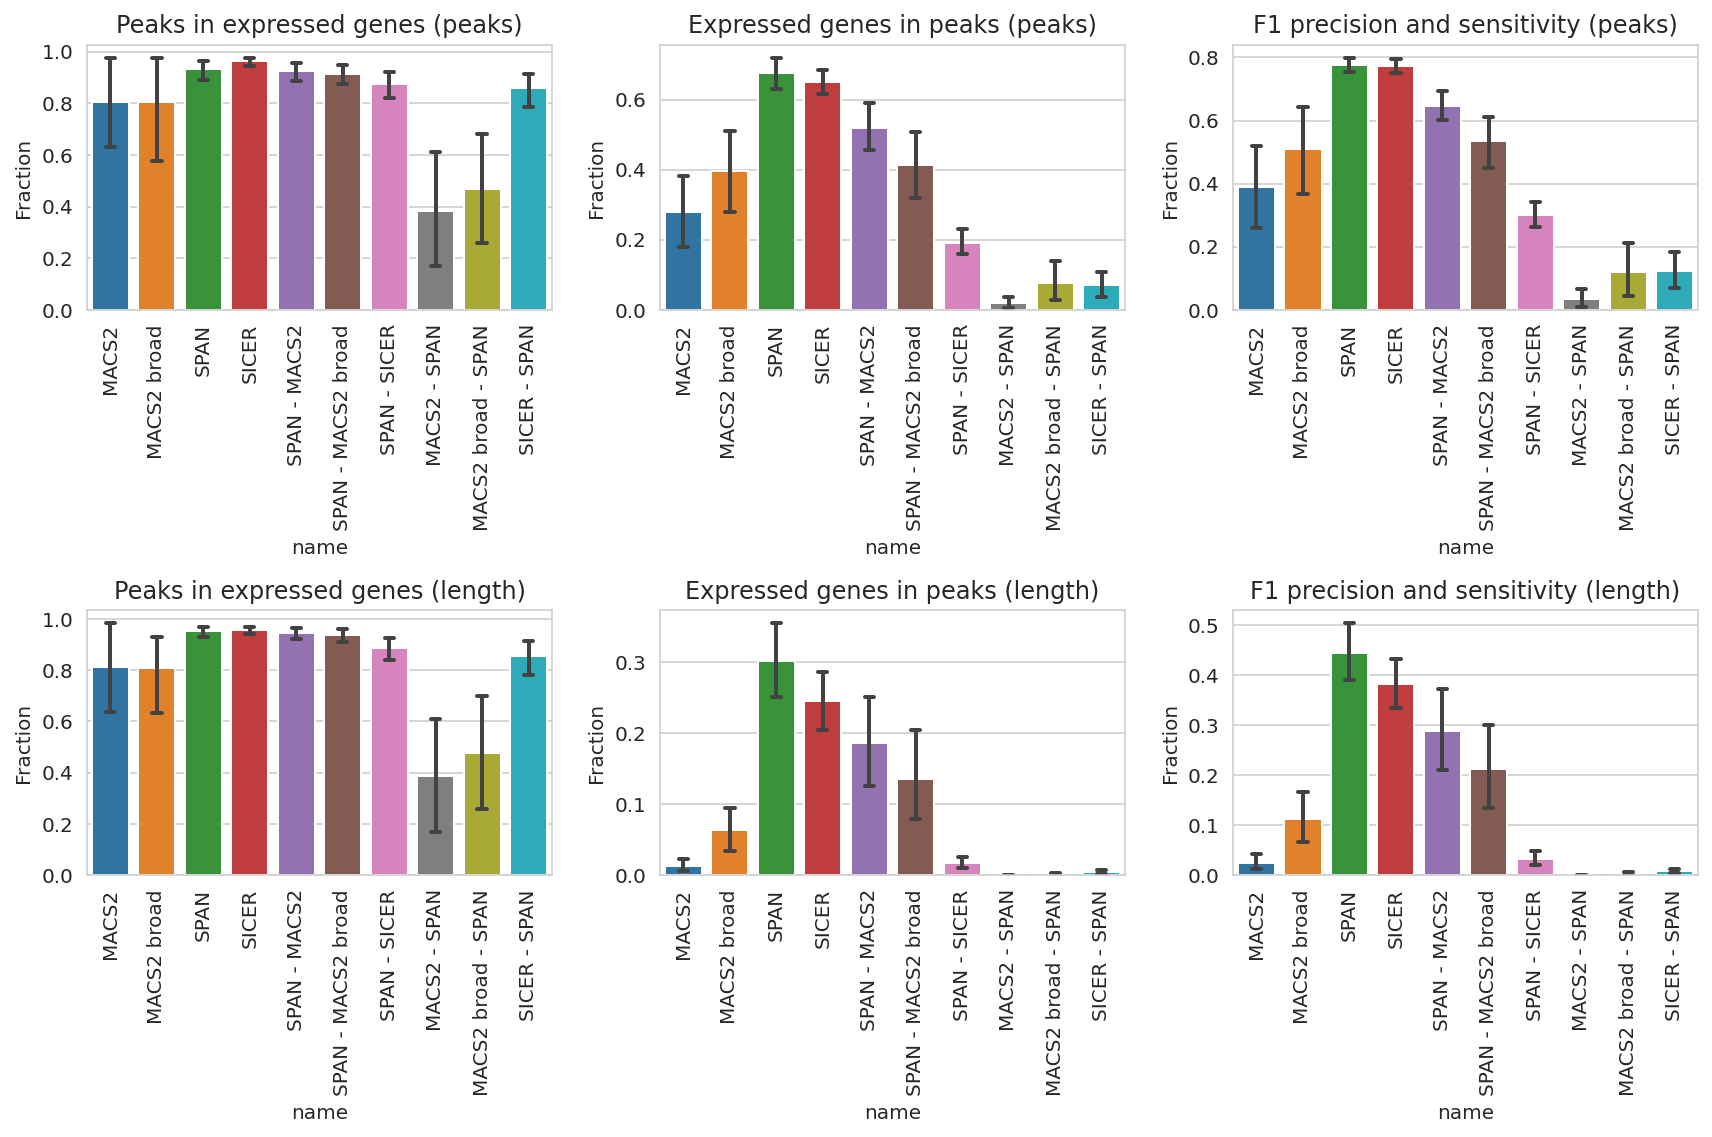

In [41]:
plt.figure(figsize=(12, 8))
axs = [plt.subplot(2, 3, i + 1) for i in range(6)]
for i, (benchmark, type) in enumerate(product(['peaks', 'length'], ['precision', 'sensitivity', 'f1'])):
    ax = axs[i]
    if type == 'precision':
        ax.title.set_text(f'Peaks in expressed genes ({benchmark})')
    elif type == 'sensitivity':
        ax.title.set_text(f'Expressed genes in peaks ({benchmark})')
    else:
        ax.title.set_text(f'F1 precision and sensitivity ({benchmark})')
    sns.barplot(data=t[(t['benchmark'] == benchmark) & (t['type'] == type)], x='name', y='value',
                capsize=.2, errwidth=2, ax=ax,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                       ])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Fraction')
plt.tight_layout()
plt.show()

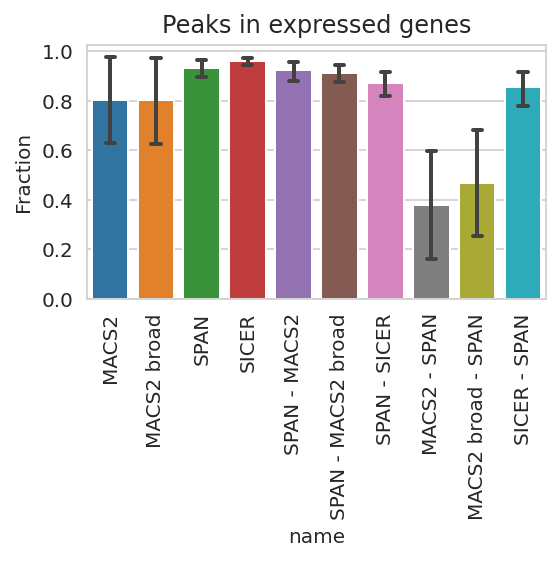

In [42]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Peaks in expressed genes')
sns.barplot(data=t[(t['benchmark'] == 'peaks') & (t['type'] == 'precision')], x='name', y='value',
            capsize=.2, errwidth=2, ax=ax,
            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                   ])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Fraction')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K36me3_peaks_in_genes.pdf', bbox_inches='tight', dpi=300)
plt.show()

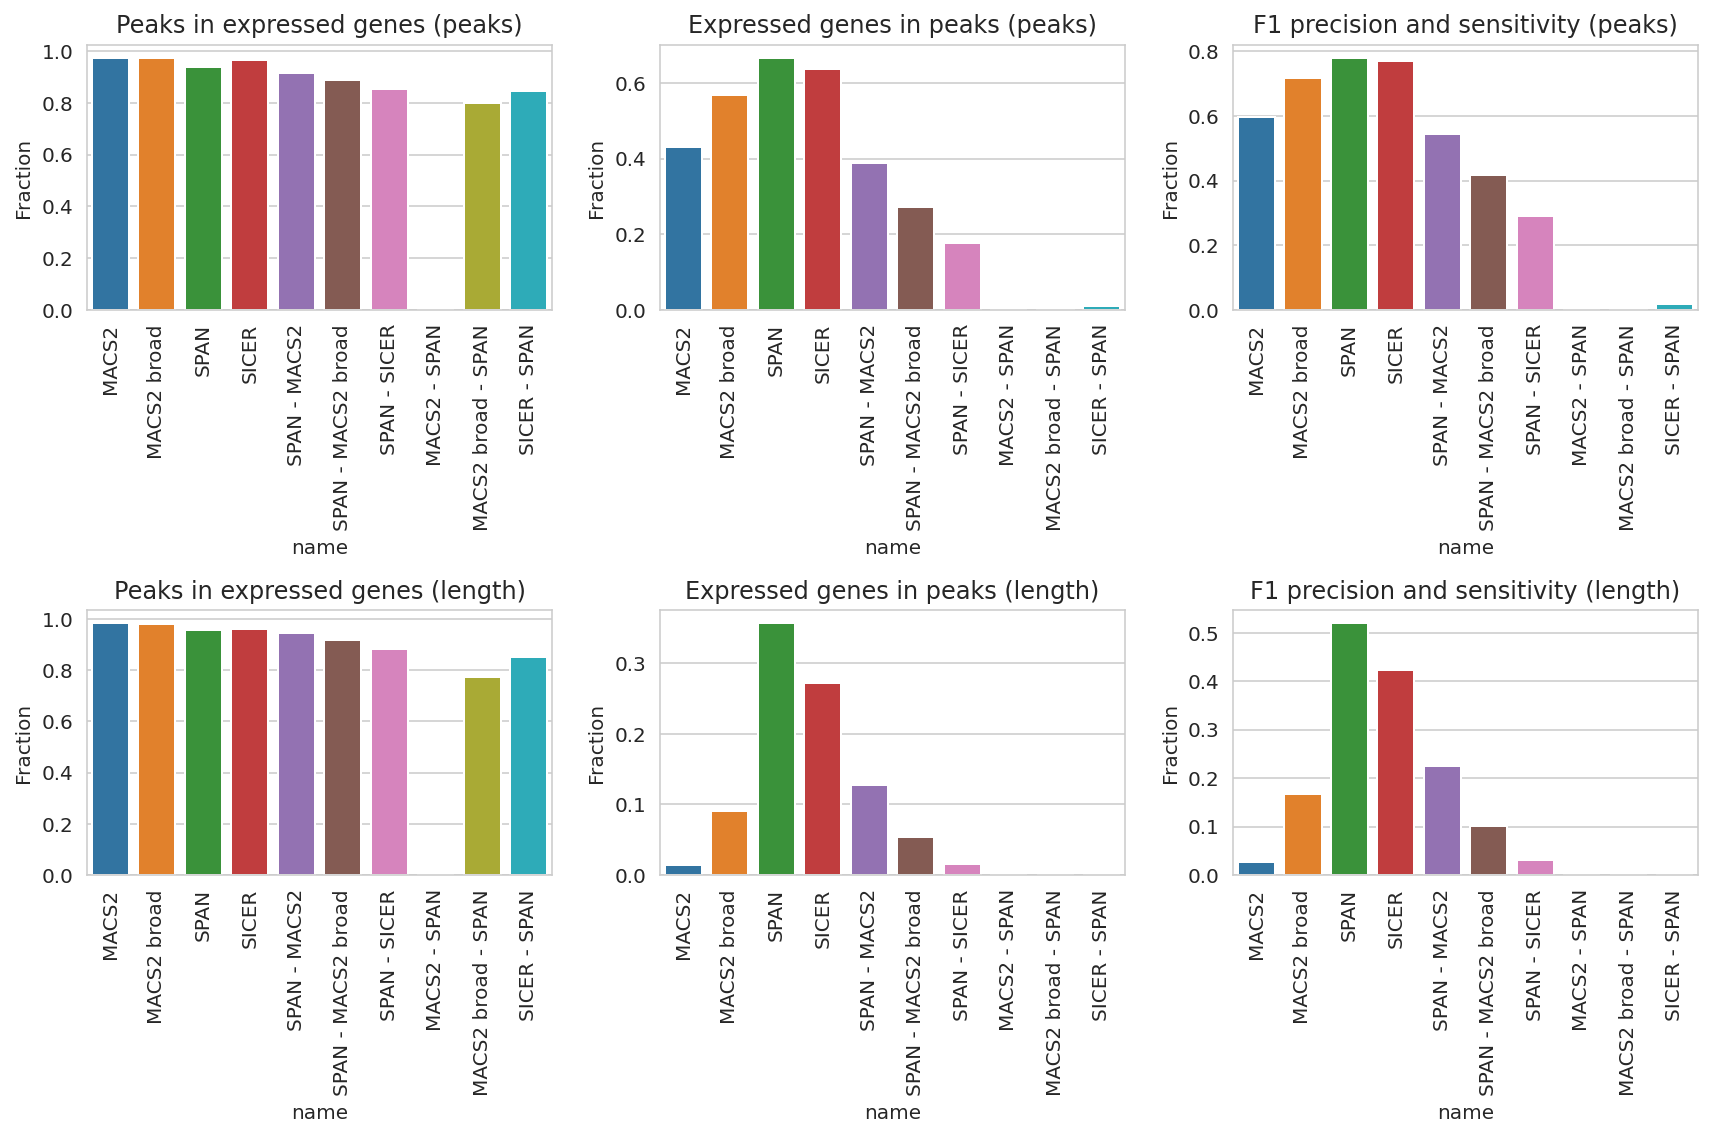

In [43]:
t = t[(t['cell'] == 'NHEK') & (t['replicate'] == 'rep2')]
plt.figure(figsize=(12, 8))
axs = [plt.subplot(2, 3, i + 1) for i in range(6)]
for i, (benchmark, type) in enumerate(product(['peaks', 'length'], ['precision', 'sensitivity', 'f1'])):
    ax = axs[i]
    if type == 'precision':
        ax.title.set_text(f'Peaks in expressed genes ({benchmark})')
    elif type == 'sensitivity':
        ax.title.set_text(f'Expressed genes in peaks ({benchmark})')
    else:
        ax.title.set_text(f'F1 precision and sensitivity ({benchmark})')
    sns.barplot(data=t[(t['benchmark'] == benchmark) & (t['type'] == type)], x='name', y='value',
                capsize=.2, errwidth=2, ax=ax,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                       ])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Fraction')
plt.tight_layout()
plt.show()

# Venn diagram analysis

In [44]:
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles


def num_format(x, engineer):
    if x <= 0:
        return ''
    elif engineer:
        return f'{x:.0e}'
    else:
        return str(x)


num_format(1.3e10, True)

VENN2_SUBSETS = ['1', '2', '1,2']
VENN2_LABELS = ['10', '01', '11']


def venn2_overlap(ax, peaks1, peaks2, overlap12, overlap21, name1, name2,
                  show_names=True, show_numbers=True, engineer=False, add_proportion=False,
                  set_font=15, subset_font=10):
    max_peaks = max(peaks1, peaks2)
    avg_overlap = (overlap12 + overlap21) / 2
    # Tweak subsets to avoid empty areas
    if show_numbers:
        subsets = (
            max(0.1 * max_peaks, min(0.9 * max_peaks, peaks1 - overlap12)) if peaks1 > overlap12 else 0,
            max(0.1 * max_peaks, min(0.9 * max_peaks, peaks2 - overlap21)) if peaks2 > overlap21 else 0,
            max(0.1 * max_peaks, min(0.9 * max_peaks, avg_overlap))
        )
    else:
        subsets = (peaks1 - overlap12, peaks2 - overlap21, avg_overlap)
    v = venn2(subsets=subsets, set_labels=(name1, name2), alpha=0.3, ax=ax)
    venn2_circles(subsets=subsets, color='grey', linewidth=1.0, ax=ax)

    if overlap12 != 0 and overlap21 != 0:
        if overlap12 > overlap21:
            prop = f'{overlap12 / overlap21:.1f} : 1'
        else:
            prop = f'1 : {overlap21 / overlap12:.1f}'
        prop = prop.replace('.0', '')  # Cosmetics
    else:
        prop = ''

    if show_numbers:
        v.get_label_by_id('10').set_text(num_format(peaks1 - overlap12, engineer))
        v.get_label_by_id('01').set_text(num_format(peaks2 - overlap21, engineer))
        if add_proportion:
            v.get_label_by_id('11').set_text(f'{overlap12} : {overlap21}\n{prop}')
        else:
            v.get_label_by_id('11').set_text(num_format(avg_overlap, engineer))
    print(f'{name1}: {peaks1 - overlap12}')
    print(f'{name2}: {peaks2 - overlap21}')
    print(f'overlap: {overlap12} : {overlap21}, {prop}')
    for label in v.set_labels:
        if label is not None:
            if show_names:
                label.set_fontsize(set_font)
            else:
                label.set_text('')
    for label in v.subset_labels:
        if label is not None:
            label.set_fontsize(subset_font)
    if not show_numbers:
        for l in VENN2_LABELS:
            label = v.get_label_by_id(l)
            if label is not None:
                label.set_text('')


VENN3_SUBSETS = ['1', '2', '1,2', '3', '1,3', '2,3', '1,2,3']
VENN3_LABELS = ['100', '010', '110', '001', '101', '011', '111']


def venn3_overlap(ax, v1, v2, v12, v3, v13, v23, v123, name1, name2, name3,
                  show_names=True, show_numbers=True, engineer=False,
                  set_font=15, subset_font=10):
    subsets = (v1, v2, v12, v3, v13, v23, v123)
    t = {l: s for l, s in zip(VENN3_LABELS, subsets)}
    v = venn3(subsets=subsets,
              set_labels=(name1, name2, name3),
              alpha=0.3,
              ax=ax)
    venn3_circles(subsets=subsets, color='grey', linewidth=1.0, ax=ax)
    for label in v.set_labels:
        if label is not None:
            if show_names:
                label.set_fontsize(set_font)
            else:
                label.set_text('')
    for label in v.subset_labels:
        if label is not None:
            label.set_fontsize(subset_font)
    for l in VENN3_LABELS:
        label = v.get_label_by_id(l)
        if label is not None:
            if not show_numbers:
                label.set_text('')
            else:
                label.set_text(num_format(t[l], engineer))

0it [00:00, ?it/s]

NHEK rep2
NHEK rep2 Venn diagrams of SPAN vs other tools (peaks)
SPAN: 18131
MACS2: 0
overlap: 7980 : 37051, 1 : 4.6
SPAN: 11807
MACS2 broad: 30
overlap: 14304 : 52465, 1 : 3.7
SPAN: 5769
SICER: 157
overlap: 20342 : 46042, 1 : 2.3


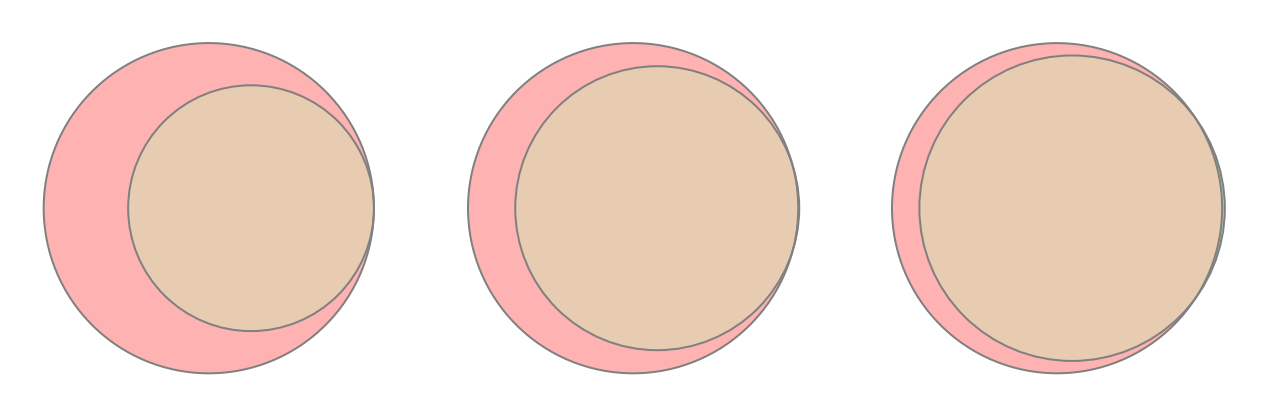

NHEK rep2 Venn diagrams of Expressed genes vs tools (peaks)
Expressed genes: 8051
MACS2: 942
overlap: 6078 : 36109, 1 : 5.9
Expressed genes: 6096
MACS2 broad: 1462
overlap: 8033 : 51033, 1 : 6.4
Expressed genes: 5111
SICER: 1523
overlap: 9018 : 44676, 1 : 5
Expressed genes: 4702
SPAN: 1612
overlap: 9427 : 24499, 1 : 2.6


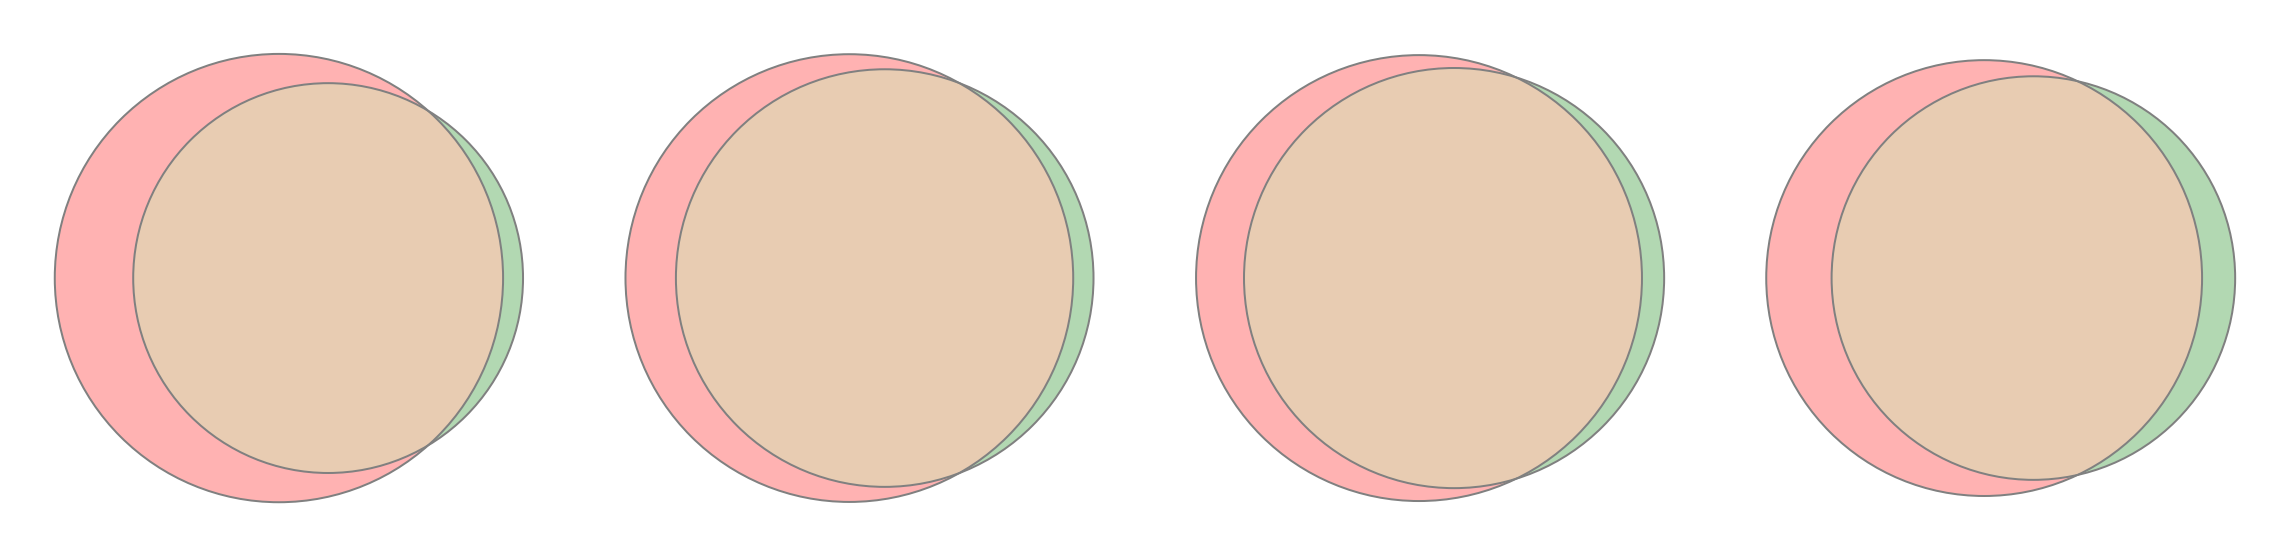

NHEK rep2 Venn diagram of SPAN vs other tools and expressed genes (length)


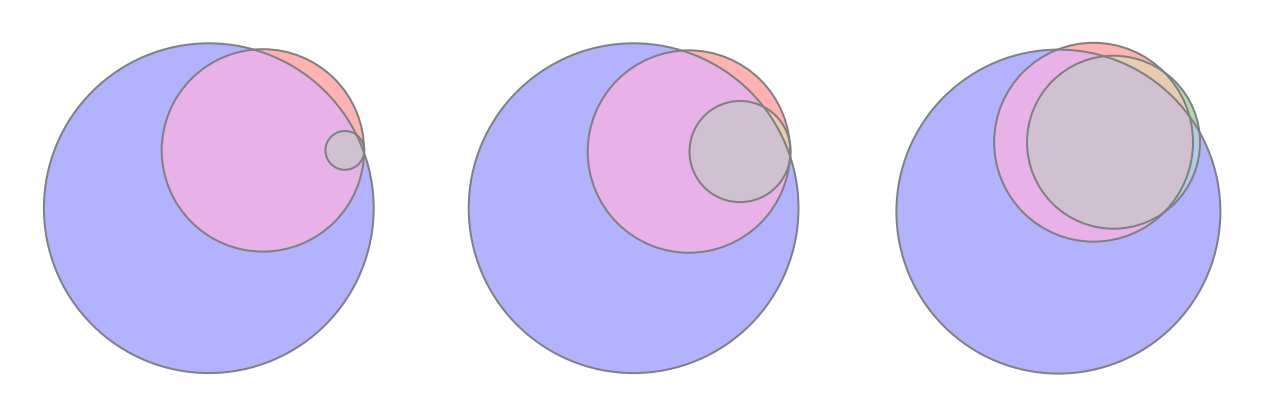

In [45]:
other_tools = list(sorted(filter(lambda t: t != 'SPAN', bench_df['name'].unique())))

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

for c, r in tqdm(product(['NHEK'], ['rep2'])):
    # for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    if (c, r) not in EXPRESSION_BED:
        continue
    print(c, r)
    expr_file = sorted_file(EXPRESSION_BED[(c, r)])
    expr_genes = lines(expr_file)
    t = df_fdr_peaks[(df_fdr_peaks['tool'] == 'SPAN') & (df_fdr_peaks['modification'] == 'H3K36me3') &
                     (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
    if len(t) == 0:
        continue
    span_file = sorted_file(t['file'].values[0])
    span_peaks = lines(span_file)
    span_len = int(bedl(span_file).sum())
    genes = lines(expr_file)
    genes_len = int(bedl(expr_file).sum())

    print(f'{c} {r} Venn diagrams of SPAN vs other tools (peaks)')
    plt.figure(figsize=(3 * len(other_tools), 3))
    axs = [plt.subplot(1, len(other_tools), i + 1) for i in range(len(other_tools))]
    for i, tool in enumerate(other_tools):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks_number = lines(peaks_file)
        !bedtools intersect -a {span_file} -b {peaks_file} -wa -u > {tf}
        span_overlap = lines(tf)
        !bedtools intersect -b {span_file} -a {peaks_file} -wa -u > {tf}
        other_overlap = lines(tf)
        venn2_overlap(axs[i], span_peaks, peaks_number, span_overlap, other_overlap, 'SPAN', tool,
                      show_names=False, show_numbers=False, add_proportion=True)
    plt.tight_layout()
    # plt.savefig(f'{GSE26320_PATH}/analyze/venn_{m}.png', bbox_inches='tight', dpi=300)
    plt.show()

    print(f'{c} {r} Venn diagrams of Expressed genes vs tools (peaks)')
    plt.figure(figsize=(4 * (len(other_tools) + 1), 4))
    axs = [plt.subplot(1, len(other_tools) + 1, i + 1) for i in range(len(other_tools) + 1)]
    for i, tool in enumerate(other_tools + ['SPAN']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks_number = lines(peaks_file)
        !bedtools intersect -a {expr_file} -b {peaks_file} -wa -u > {tf}
        expr_overlap = lines(tf)
        !bedtools intersect -b {expr_file} -a {peaks_file} -wa -u > {tf}
        peaks_overlap = lines(tf)
        venn2_overlap(axs[i], expr_genes, peaks_number, expr_overlap, peaks_overlap, 'Expressed genes', tool,
                      show_names=False, show_numbers=False, add_proportion=True)
    plt.tight_layout()
    # plt.savefig(f'{GSE26320_PATH}/analyze/venn_{m}.png', bbox_inches='tight', dpi=300)
    plt.show()

    print(f'{c} {r} Venn diagram of SPAN vs other tools and expressed genes (length)')
    plt.figure(figsize=(3 * len(other_tools), 3))
    axs = [plt.subplot(1, len(other_tools), i + 1) for i in range(len(other_tools))]
    for i, tool in enumerate(other_tools):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks_number = lines(peaks_file)
        peaks_len = int(bedl(peaks_file).sum())
        ! bedtools multiinter -i {span_file} {peaks_file} {expr_file} > {tf}
        t = pd.read_csv(tf, sep='\t', names=['chr', 'start', 'end',
                                             'overlap_number', 'overlap_details',
                                             'overlap1', 'overlap2', 'overlap3'])
        venn3_overlap(axs[i], *[
            (t[t['overlap_details'] == o]['end'] - t[t['overlap_details'] == o]['start']).sum()
            for o in VENN3_SUBSETS
        ], 'SPAN', tool, 'Expressed genes', show_names=False, show_numbers=False, engineer=True)

    plt.tight_layout()
    plt.show()

# Hg38 Compare peaks to express genes ratios

In [46]:
import tempfile
from itertools import product

tf = tempfile.mktemp()

ratio_df = pd.DataFrame(columns=['cell', 'replicate', 'tool', 'genes', 'peaks'], dtype=object)

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    if (c, r) not in EXPRESSION_BED:
        continue
    expr_file = sorted_file(EXPRESSION_BED[c, r])
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        expr_cols = len(pd.read_csv(expr_file, sep='\t', header=None, nrows=1).columns)
        !bedtools intersect -a {expr_file} -b {peaks_file} -wa -wb > {tf}
        try:
            tf_expression = pd.read_csv(tf, sep='\t', header=None)
            genes = len(tf_expression.groupby([0, 1, 2]).count())
            peaks = len(tf_expression.groupby([expr_cols, expr_cols + 1, expr_cols + 2]).count())
            ratio_df.loc[len(ratio_df)] = (c, r, tool, genes, peaks)
        except:
            pass

ratio_df

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


cell replicate         tool  genes  peaks
0   GM12878      rep1        SICER   8546  32253
1   GM12878      rep1         SPAN   8880  19721
2   GM12878      rep1        MACS2   4534  19387
3   GM12878      rep1  MACS2 broad   4369  13572
4   GM12878      rep2        SICER   8555  32224
..      ...       ...          ...    ...    ...
61    HepG2      rep1  MACS2 broad   7990  45947
62    HepG2      rep2        SICER   8565  41066
63    HepG2      rep2         SPAN   7667  26116
64    HepG2      rep2        MACS2   1292   3539
65    HepG2      rep2  MACS2 broad   7871  45930

[66 rows x 5 columns]

In [47]:
ratio_df['peaks_to_genes'] = ratio_df['peaks'] / ratio_df['genes']
ratio_df.sort_values(by=['tool'], inplace=True)

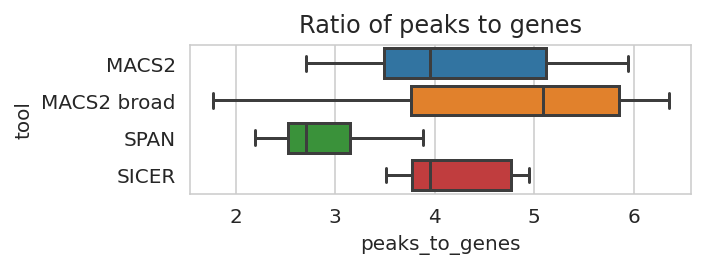

In [48]:
plt.figure(figsize=(5, 2))
ax = plt.axes()
g_results = sns.boxplot(data=ratio_df[ratio_df['peaks_to_genes'] < 10], x='peaks_to_genes', y='tool', ax=ax,
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
ax.title.set_text('Ratio of peaks to genes')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K36me3_ratios.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Hg38 H3K36me3 TPM benchmark

Benchmark according to the paper https://doi.org/10.1093/bib/bbw035
Features that define the best ChIP-seq peak calling algorithms

We considered a peak as positive if it overlaps an active gene (defined varying RPKM from 0 to 2)
and compared methods based on sensitivity, precision and F-score.

In [49]:
import tempfile
from itertools import product

tf = tempfile.mktemp()
expr_file = tempfile.mktemp()

benchmark_tpm_df = pd.DataFrame(
    columns=['cell', 'replicate', 'tpm', 'genes', 'peaks_file', 'peaks', 'pg', 'gp', 'overlap', 'tool'],
    dtype=object
)

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    if (c, r) not in EXPRESSION_TSV:
        continue

    t = pd.read_csv(GSE26320_RNASEQ_PATH + '/' + EXPRESSION_TSV[c, r], sep='\t')
    # Fix . in gene_id
    t['gene_id'] = [re.sub('\..*', '', id) for id in t['gene_id']]
    t['LTPM'] = np.log1p(t['TPM'])
    full_df = pd.merge(left=t, right=gtf_genes_df, left_on='gene_id', right_on='gene_id')
    full_df = full_df[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM']]
    full_df.sort_values(by=['chromosome', 'start'], inplace=True)
    full_df = merge_genes(full_df)

    for tpm in np.linspace(0, 0.5, 6):
        print('Processing TMP', tpm)
        full_df[full_df['LTPM'] > tpm].to_csv(expr_file, sep='\t', index=False, header=None)
        expr_file = sorted_file(expr_file)
        genes = lines(expr_file)
        for tool in df_fdr_peaks['tool'].unique():
            t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K36me3') &
                             (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
            if len(t) == 0:
                continue
            peaks_file = sorted_file(t['file'].values[0])
            peaks = lines(peaks_file)
            for overlap, overlap_param in [
                ('1bp', ''),
                ('50%', ' -f 0.5 ')
            ]:
                !bedtools intersect -a {peaks_file} -b {expr_file} -wa -u {overlap_param} > {tf}
                peaks_overlap = lines(tf)
                !bedtools intersect -b {peaks_file} -a {expr_file} -wa -u {overlap_param} > {tf}
                genes_overlap = lines(tf)
                benchmark_tpm_df.loc[len(benchmark_tpm_df)] = \
                    (c, r, tpm, genes, peaks_file, peaks, peaks_overlap, genes_overlap, overlap, tool)

benchmark_tpm_df

0it [00:00, ?it/s]

GM12878 rep1
Merging overlapping regions 58387
Reduced to 42816
Processing TMP 0.0
Processing TMP 0.1
Processing TMP 0.2
Processing TMP 0.30000000000000004
Processing TMP 0.4
Processing TMP 0.5
GM12878 rep2
Merging overlapping regions 56646
Reduced to 41996
Processing TMP 0.0
Processing TMP 0.1
Processing TMP 0.2
Processing TMP 0.30000000000000004
Processing TMP 0.4
Processing TMP 0.5
HMEC rep1
Merging overlapping regions 58387
Reduced to 42816
Processing TMP 0.0
Processing TMP 0.1
Processing TMP 0.2
Processing TMP 0.30000000000000004
Processing TMP 0.4
Processing TMP 0.5
HMEC rep2
Merging overlapping regions 58387
Reduced to 42816
Processing TMP 0.0
Processing TMP 0.1
Processing TMP 0.2
Processing TMP 0.30000000000000004
Processing TMP 0.4
Processing TMP 0.5
HSMM rep1
Merging overlapping regions 52065
Reduced to 38702
Processing TMP 0.0
Processing TMP 0.1
Processing TMP 0.2
Processing TMP 0.30000000000000004
Processing TMP 0.4
Processing TMP 0.5
HSMM rep2
Merging overlapping regions 5

cell replicate  tpm  genes        peaks_file  peaks     pg    gp  \
0    GM12878      rep1  0.0  17061  /tmp/tmpfzthy4ll   1741   1716  1152   
1    GM12878      rep1  0.0  17061  /tmp/tmpfzthy4ll   1741   1711     2   
2    GM12878      rep1  0.0  17061  /tmp/tmp8p9zjjxi  13794  13610  4635   
3    GM12878      rep1  0.0  17061  /tmp/tmp8p9zjjxi  13794  13519    66   
4    GM12878      rep1  0.0  17061  /tmp/tmpxdvhgd9x  29804  29370  9358   
..       ...       ...  ...    ...               ...    ...    ...   ...   
811    HepG2      rep2  0.5  10725  /tmp/tmpd8oraglc   4769   4709    16   
812    HepG2      rep2  0.5  10725  /tmp/tmp4itng3nv  41709  40355  8597   
813    HepG2      rep2  0.5  10725  /tmp/tmp4itng3nv  41709  40073  1962   
814    HepG2      rep2  0.5  10725  /tmp/tmpjvtbr93f  29492  28306  8687   
815    HepG2      rep2  0.5  10725  /tmp/tmpjvtbr93f  29492  28102  2970   

    overlap         tool  
0       1bp        MACS2  
1       50%        MACS2  
2       1bp  MACS2 broad  
3       50%  MACS2 broad  
4       1bp        SICER  
..      ...          ...  
811     50%  MACS2 broad  
812     1bp        SICER  
813     50%        SICER  
814     1bp         SPAN  
815     50%         SPAN  

[816 rows x 10 columns]

In [50]:
benchmark_tpm_df['p'] = (benchmark_tpm_df['pg'] + benchmark_tpm_df['gp']) / 2
benchmark_tpm_df['precision'] = [d(x, y) for x, y in zip(benchmark_tpm_df['pg'], benchmark_tpm_df['peaks'])]
benchmark_tpm_df['sensitivity'] = [d(x, y) for x, y in zip(benchmark_tpm_df['gp'], benchmark_tpm_df['genes'])]
benchmark_tpm_df['f1'] = [2 / (d(1, s + 1e-10) + d(1, p + 1e-10)) for s, p in
                          zip(benchmark_tpm_df['sensitivity'], benchmark_tpm_df['precision'])]
benchmark_tpm_df

cell replicate  tpm  genes        peaks_file  peaks     pg    gp  \
0    GM12878      rep1  0.0  17061  /tmp/tmpfzthy4ll   1741   1716  1152   
1    GM12878      rep1  0.0  17061  /tmp/tmpfzthy4ll   1741   1711     2   
2    GM12878      rep1  0.0  17061  /tmp/tmp8p9zjjxi  13794  13610  4635   
3    GM12878      rep1  0.0  17061  /tmp/tmp8p9zjjxi  13794  13519    66   
4    GM12878      rep1  0.0  17061  /tmp/tmpxdvhgd9x  29804  29370  9358   
..       ...       ...  ...    ...               ...    ...    ...   ...   
811    HepG2      rep2  0.5  10725  /tmp/tmpd8oraglc   4769   4709    16   
812    HepG2      rep2  0.5  10725  /tmp/tmp4itng3nv  41709  40355  8597   
813    HepG2      rep2  0.5  10725  /tmp/tmp4itng3nv  41709  40073  1962   
814    HepG2      rep2  0.5  10725  /tmp/tmpjvtbr93f  29492  28306  8687   
815    HepG2      rep2  0.5  10725  /tmp/tmpjvtbr93f  29492  28102  2970   

    overlap         tool        p  precision  sensitivity        f1  
0       1bp        MACS2   1434.0   0.985640     0.067522  0.126387  
1       50%        MACS2    856.5   0.982769     0.000117  0.000234  
2       1bp  MACS2 broad   9122.5   0.986661     0.271672  0.426037  
3       50%  MACS2 broad   6792.5   0.980064     0.003868  0.007707  
4       1bp        SICER  19364.0   0.985438     0.548502  0.704741  
..      ...          ...      ...        ...          ...       ...  
811     50%  MACS2 broad   2362.5   0.987419     0.001492  0.002979  
812     1bp        SICER  24476.0   0.967537     0.801585  0.876778  
813     50%        SICER  21017.5   0.960776     0.182937  0.307353  
814     1bp         SPAN  18496.5   0.959786     0.809977  0.878541  
815     50%         SPAN  15536.0   0.952869     0.276923  0.429132  

[816 rows x 14 columns]

In [51]:
def rgb2hex(color):
    r, g, b, _ = color
    return "#{0:02x}{1:02x}{2:02x}".format(int(r * 255), int(g * 255), int(b * 255))


PLOTLY_TOOLS_PALETTE = {k: rgb2hex(v) for k, v in TOOLS_PALETTE.items()}

In [52]:
import plotly.graph_objects as go
import plotly.express as px

def plot_tpm(benchmark_tpm_df):
    tools_legend_shown = set()
    fig = go.Figure()
    for overlap in benchmark_tpm_df['overlap'].unique():
        marker = 'square' if overlap == '1bp' else 'circle' if overlap == '50%' else 'diamond'
        for c, r, t in product(GSE26320_CELLS, GSE26320_REPS, df_fdr_peaks['tool'].unique()):
            dft = benchmark_tpm_df[(benchmark_tpm_df['cell'] == c) & (benchmark_tpm_df['replicate'] == r) &
                                   (benchmark_tpm_df['overlap'] == overlap) & (benchmark_tpm_df['tool'] == t)]
            if len(dft) == 0:
                continue
            fig.add_trace(go.Scatter(
                x=dft["precision"], y=dft["sensitivity"], mode='lines+markers', name=t,
                hovertext=dft['tpm'].astype(str) + ' ' + t, marker_symbol=[marker] * len(dft),
                showlegend=t not in tools_legend_shown,
                marker_color=PLOTLY_TOOLS_PALETTE[t],
                opacity=0.5,
            ))
            tools_legend_shown.add(t)

    for overlap in set(benchmark_tpm_df['overlap']):
        marker = 'square' if overlap == '1bp' else 'circle' if overlap == '50%' else 'diamond'
        for c, r, t in product(GSE26320_CELLS, GSE26320_REPS, df_fdr_peaks['tool'].unique()):
            dft = benchmark_tpm_df[(benchmark_tpm_df['cell'] == c) & (benchmark_tpm_df['replicate'] == r) &
                                   (benchmark_tpm_df['overlap'] == overlap) & (benchmark_tpm_df['tool'] == t) &
                                   (benchmark_tpm_df['tpm'] == 0.1)]
            if len(dft) == 0:
                continue
            fig.add_trace(
                go.Scatter(
                    mode='markers',
                    x=dft["precision"], y=dft["sensitivity"],
                    name=t,
                    marker=dict(color='white', size=5, line=dict(width=1), symbol=marker),
                    showlegend=False,
                    hovertext=dft['tpm'].astype(str) + ' ' + t
                )
            )

    fig.update_xaxes(range=[-0.1, 1.1], title='Peaks in active genes (precision)')
    fig.update_yaxes(range=[-0.1, 1.1], title='Active genes in peaks (sensitivity)')
    # fig.update_xaxes(title='Peaks overlapping active genes (precision)')
    # fig.update_yaxes(title='Active genes overlapping peaks (sensitivity)')

    fig.layout.template = 'plotly_white'
    fig.update_layout(
        autosize=False,
        width=800,
        height=600, )
    fig.show()


In [53]:
plot_tpm(benchmark_tpm_df[(benchmark_tpm_df['overlap'] == '1bp') &
                          (benchmark_tpm_df['cell'] == 'K562') &
                          (benchmark_tpm_df['replicate'] == 'rep1')])

In [54]:
plot_tpm(benchmark_tpm_df[benchmark_tpm_df['overlap'] == '1bp'])

In [55]:
plot_tpm(benchmark_tpm_df[benchmark_tpm_df['overlap'] == '50%'])

# Coverage

In [56]:
GSE26320_HG38_PATH_BW = GSE26320_PATH_HG38 + '/bw'


def load_bws(path, m):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        cell = next((cc for cc in GSE26320_CELLS if cc in f), None)
        rep = 'rep1' if 'rep1' in f else 'rep2'
        if cell and rep and m in f:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), m, cell, rep)
    return df_bws

In [57]:
bws_df = load_bws(GSE26320_HG38_PATH_BW, 'H3K36me3')
bws_df.sample(5)

  0%|          | 0/103 [00:00<?, ?it/s]

file modification     cell  \
6  /home/jetbrains/data/2023_GSE26320/bw/GSM64643...     H3K36me3     K562   
2  /home/jetbrains/data/2023_GSE26320/bw/GSM64637...     H3K36me3     HMEC   
5  /home/jetbrains/data/2023_GSE26320/bw/GSM64632...     H3K36me3  GM12878   
4  /home/jetbrains/data/2023_GSE26320/bw/GSM64646...     H3K36me3     NHEK   
1  /home/jetbrains/data/2023_GSE26320/bw/GSM64641...     H3K36me3    Huvec   

  replicate  
6      rep1  
2      rep1  
5      rep1  
4      rep2  
1      rep1

In [58]:
bws_control_df = load_bws(GSE26320_HG38_PATH_BW, 'Input')
bws_control_df.sample(5)

  0%|          | 0/103 [00:00<?, ?it/s]

file modification     cell  \
7   /home/jetbrains/data/2023_GSE26320/bw/GSM64633...        Input  GM12878   
9   /home/jetbrains/data/2023_GSE26320/bw/GSM64639...        Input     HMEC   
10  /home/jetbrains/data/2023_GSE26320/bw/GSM64637...        Input    HepG2   
4   /home/jetbrains/data/2023_GSE26320/bw/GSM64649...        Input     NHLF   
17  /home/jetbrains/data/2023_GSE26320/bw/GSM64645...        Input     K562   

   replicate  
7       rep2  
9       rep2  
10      rep2  
4       rep1  
17      rep1

In [59]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH_HG38, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}
CHROM_SIZES

{'chr1': 248956422,
 'chr2': 242193529,
 'chr3': 198295559,
 'chr4': 190214555,
 'chr5': 181538259,
 'chr6': 170805979,
 'chr7': 159345973,
 'chrX': 156040895,
 'chr8': 145138636,
 'chr9': 138394717,
 'chr11': 135086622,
 'chr10': 133797422,
 'chr12': 133275309,
 'chr13': 114364328,
 'chr14': 107043718,
 'chr15': 101991189,
 'chr16': 90338345,
 'chr17': 83257441,
 'chr18': 80373285,
 'chr20': 64444167,
 'chr19': 58617616,
 'chrY': 57227415,
 'chr22': 50818468,
 'chr21': 46709983,
 'chrM': 16569}

## FRIP

In [60]:
import pyBigWig

tf = tempfile.mktemp()

frip_df = pd.DataFrame(
    columns=['cell', 'replicate', 'bw_file', 'tool', 'peaks_file', 'peaks', 'length',
             'reads_in_peaks', 'all_reads', 'control_reads_in_peaks', 'control_all_reads'],
    dtype=object
)

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    # for c, r in tqdm(product(['GM12878'], ['rep1'])):
    print(c, r)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        if peaks == 0:
            continue
        peaks_len = int(bedl(peaks_file).sum())
        t = bws_df[(bws_df['modification'] == 'H3K36me3') &
                   (bws_df['cell'] == c) & (bws_df['replicate'] == r)]
        if len(t) == 0:
            continue
        bw_file = t['file'].values[0]
        t = bws_control_df[(bws_control_df['cell'] == c) & (bws_control_df['replicate'] == r)]
        if len(t) == 0:
            continue
        bw_control_file = t['file'].values[0]

        print(tool, peaks_file, bw_file, bw_control_file)
        t = pd.read_csv(peaks_file, sep='\t', header=None)
        with pyBigWig.open(bw_file) as bw:
            total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
            peaks_coverage = sum(bw.stats(chr, start, end, type='sum', exact=True)[0]
                                 for chr, start, end in zip(t[0], t[1], t[2]))
        with pyBigWig.open(bw_control_file) as bwc:
            control_total_coverage = sum(
                bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
            control_peaks_coverage = sum(bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                         for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES)
        frip_df.loc[len(frip_df)] = (c, r, bw_file, tool, peaks_file, peaks, peaks_len,
                                     peaks_coverage, total_coverage, control_peaks_coverage, control_total_coverage)

frip_df

0it [00:00, ?it/s]

GM12878 rep1
SICER /tmp/tmpd5b9w34k /home/jetbrains/data/2023_GSE26320/bw/GSM646320_GM12878_H3K36me3_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
SPAN /tmp/tmpimdb6sze /home/jetbrains/data/2023_GSE26320/bw/GSM646320_GM12878_H3K36me3_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
MACS2 /tmp/tmp_a316_3c /home/jetbrains/data/2023_GSE26320/bw/GSM646320_GM12878_H3K36me3_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
MACS2 broad /tmp/tmpne8ipprc /home/jetbrains/data/2023_GSE26320/bw/GSM646320_GM12878_H3K36me3_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
GM12878 rep2
SICER /tmp/tmpcr9_2bjx /home/jetbrains/data/2023_GSE26320/bw/GSM646321_GM12878_H3K36me3_rep2.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646333_GM12878_Input_rep2.bw
SPAN /tmp/tmp19hek9dq /home/jetbrains/data/2023_GSE26320/bw/GSM646321_GM12878_H3K36me3_rep2.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646

cell replicate                                            bw_file  \
0   GM12878      rep1  /home/jetbrains/data/2023_GSE26320/bw/GSM64632...   
1   GM12878      rep1  /home/jetbrains/data/2023_GSE26320/bw/GSM64632...   
2   GM12878      rep1  /home/jetbrains/data/2023_GSE26320/bw/GSM64632...   
3   GM12878      rep1  /home/jetbrains/data/2023_GSE26320/bw/GSM64632...   
4   GM12878      rep2  /home/jetbrains/data/2023_GSE26320/bw/GSM64632...   
..      ...       ...                                                ...   
59    HepG2      rep1  /home/jetbrains/data/2023_GSE26320/bw/GSM64635...   
60    HepG2      rep2  /home/jetbrains/data/2023_GSE26320/bw/GSM64636...   
61    HepG2      rep2  /home/jetbrains/data/2023_GSE26320/bw/GSM64636...   
62    HepG2      rep2  /home/jetbrains/data/2023_GSE26320/bw/GSM64636...   
63    HepG2      rep2  /home/jetbrains/data/2023_GSE26320/bw/GSM64636...   

           tool        peaks_file  peaks     length  reads_in_peaks  \
0         SICER  /tmp/tmpd5b9w34k  29804  311146596     410530925.0   
1          SPAN  /tmp/tmpimdb6sze  19448  362352507     443831076.0   
2         MACS2  /tmp/tmp_a316_3c   1741     667402       2946533.0   
3   MACS2 broad  /tmp/tmpne8ipprc  13794   18238909      47565467.0   
4         SICER  /tmp/tmpcr9_2bjx  33007  312709793     417760233.0   
..          ...               ...    ...        ...             ...   
59  MACS2 broad  /tmp/tmpqz8fqgdg  46757   93659707     100556540.0   
60        SICER  /tmp/tmpusqn0uxr  41709  240863691     286278812.0   
61         SPAN  /tmp/tmpmrirbait  29492  268136020     297322064.0   
62        MACS2  /tmp/tmpqca9f4dn   3561    1707621       8364130.0   
63  MACS2 broad  /tmp/tmpajmbabnd   4769    6929122      23898493.0   

      all_reads  control_reads_in_peaks  control_all_reads  
0   952318750.0              75741698.0        561810400.0  
1   952556606.0              87755909.0        561810400.0  
2   952318750.0                 55403.0        561810400.0  
3   952318750.0               3356526.0        561810400.0  
4   799786200.0              73364158.0        538061350.0  
..          ...                     ...                ...  
59  472970000.0              28864864.0        736768500.0  
60  415177450.0               8449233.0         97138700.0  
61  415338750.0               9715335.0         97138700.0  
62  407804150.0                   524.0         94474650.0  
63  407804150.0                 84217.0         94474650.0  

[64 rows x 11 columns]

In [61]:
frip_df['frip'] = [d(x, y) for x, y in zip(frip_df['reads_in_peaks'], frip_df['all_reads'])]
frip_df['peaks_rpkm'] = [(x / ((z + 1e-10) / 1e3)) / ((y + 1e-10) / 1e6) for x, y, z in
                         zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])]
frip_df['peaks_background_log2fc'] = [
    np.log2((x / (z + 1e-10)) / ((y - x) / (sum(CHROM_SIZES.values()) - z + 1e-10)))
    for x, y, z in zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])
]
frip_df['peaks_control_log2fc'] = [
    np.log2(d(x / ((y + 1e-10) / 1e6), z / ((u + 1e-10) / 1e6) + 1e-10))
    for x, y, z, u in zip(frip_df['reads_in_peaks'], frip_df['all_reads'],
                          frip_df['control_reads_in_peaks'], frip_df['control_all_reads'])
]

In [62]:
# Ignore outliers
t = frip_df[frip_df['peaks'] > 100]

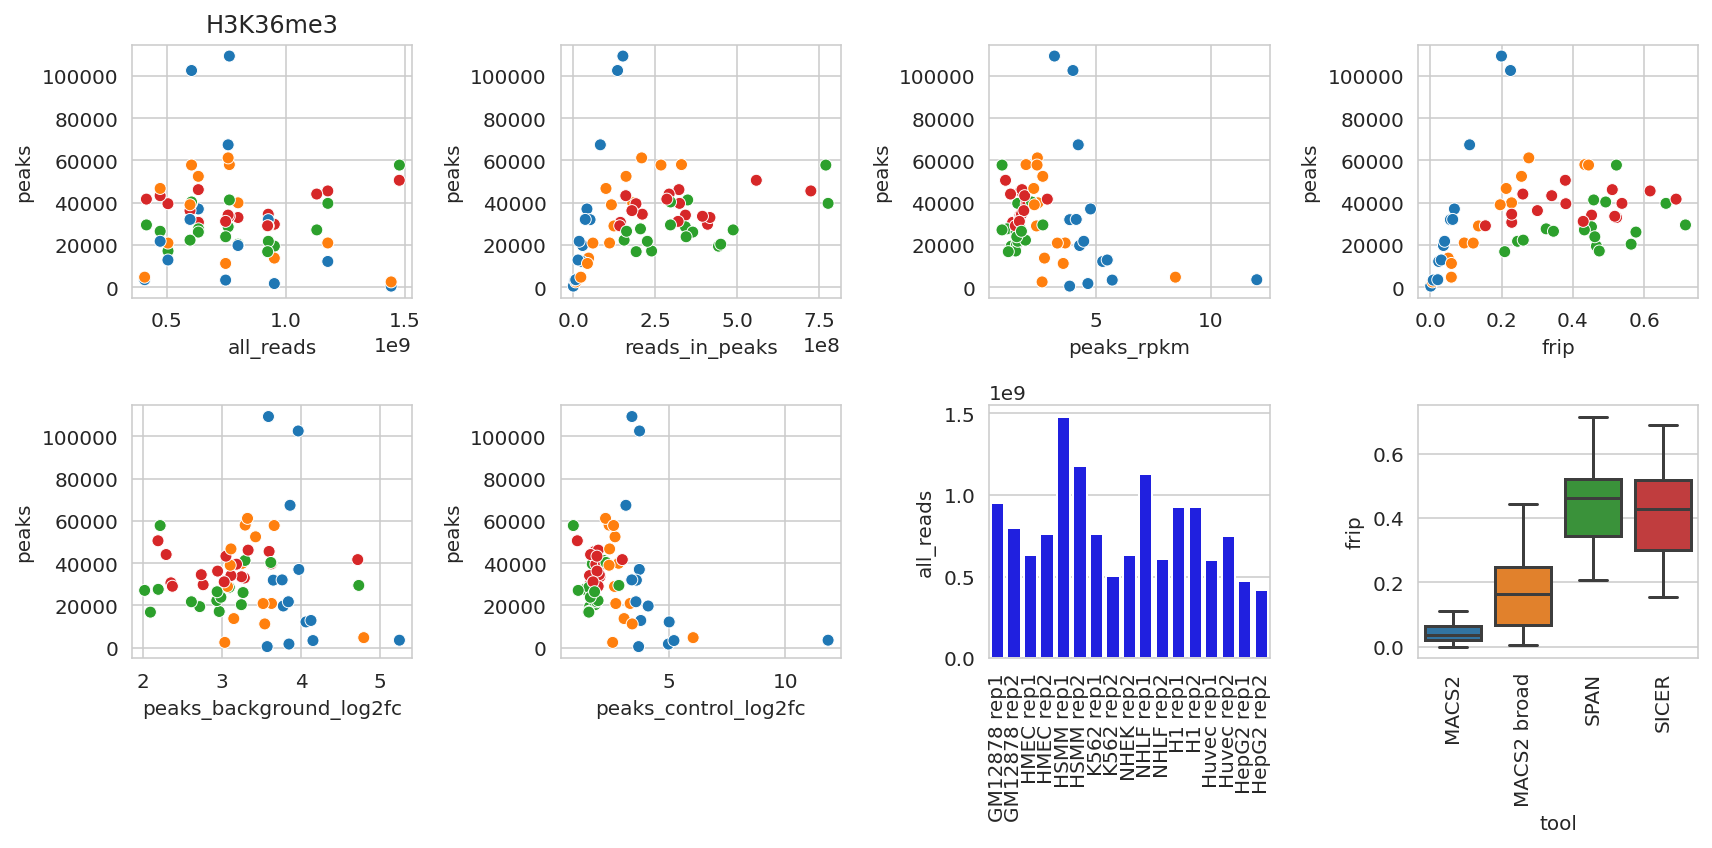

In [63]:
import seaborn as sns

plt.figure(figsize=(12, 6))
axs = [plt.subplot(2, 4, i + 1) for i in range(8)]
ax = axs[0]
ax.set_title('H3K36me3')
g_results = sns.scatterplot(data=t, x='all_reads', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[1]
g_results = sns.scatterplot(data=t, x='reads_in_peaks', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[2]
g_results = sns.scatterplot(data=t, x='peaks_rpkm', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[3]
g_results = sns.scatterplot(data=t, x='frip', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[4]
g_results = sns.scatterplot(data=t, x='peaks_background_log2fc', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[5]
g_results = sns.scatterplot(data=t, x='peaks_control_log2fc', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[6]
tt = t[t['tool'] == 'SPAN']
g_results = sns.barplot(x=tt['cell'] + ' ' + tt['replicate'], y=tt['all_reads'],
                        color='Blue',
                        # order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# g_results.axes.legend().set_visible(False)


ax = axs[7]
g_results = sns.boxplot(data=t, x='tool', y='frip',
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        showfliers=False,
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# g_results.axes.legend().set_visible(False)
# Put a legend to the right of the current axis
# g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K36me3_reads.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Compute BAM reads

In [64]:
def load_bams(path, m):
    df_bams = pd.DataFrame(columns=['bam_file', 'modification', 'cell', 'replicate', 'mapped_reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        cell = next((cc for cc in GSE26320_CELLS if cc in f), None)
        rep = 'rep1' if 'rep1' in f else 'rep2'
        if cell and rep and m in f:
            file = os.path.join(path, f)
            reads = ! samtools view -F 0x04 -c {file}
            reads = int(reads[0])
            df_bams.loc[len(df_bams)] = (file, m, cell, rep, reads)
    return df_bams

bams_df = load_bams(GSE26320_PATH_HG38 + '/bams', 'H3K36me3')
bams_df

  0%|          | 0/206 [00:00<?, ?it/s]

bam_file modification     cell  \
0   /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3     NHLF   
1   /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3     NHEK   
2   /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3    Huvec   
3   /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3     NHLF   
4   /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3     HSMM   
5   /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3  GM12878   
6   /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3       H1   
7   /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3     HSMM   
8   /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3    HepG2   
9   /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3     K562   
10  /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3    HepG2   
11  /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3     K562   
12  /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3     HMEC   
13  /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3     HMEC   
14  /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3    Huvec   
15  /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3       H1   
16  /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3  GM12878   

   replicate  mapped_reads  
0       rep1      14385159  
1       rep2       7569713  
2       rep1       6615540  
3       rep2       7454735  
4       rep2      14341735  
5       rep1      10272353  
6       rep2      12119359  
7       rep1      18449188  
8       rep1       5672019  
9       rep2       7439053  
10      rep2       5270026  
11      rep1       9543326  
12      rep2       9203385  
13      rep1       7610194  
14      rep2       9066914  
15      rep1      11338444  
16      rep2       8126028

In [65]:
t = pd.merge(frip_df, bams_df, left_on=['cell', 'replicate'], right_on=['cell', 'replicate'])

In [66]:
t['dataset'] = 'Encode'
t.to_csv('/tmp/encode.tsv', sep='\t', index=False)

## Aggregated info ENCODE and Immune

In [67]:
t = pd.concat([
    pd.read_csv('/tmp/encode.tsv', sep='\t'),
    pd.read_csv('/tmp/immune.tsv', sep='\t'),
]).reset_index(drop=True)
t.sample(5)

cell replicate                                            bw_file  \
59     HepG2      rep1  /home/jetbrains/data/2023_GSE26320/bw/GSM64635...   
74  Monocyte      rep2  /home/jetbrains/data/2023_Immune/bw/Monocyte_H...   
64     BCell      rep2  /home/jetbrains/data/2023_Immune/bw/BCell_H3K3...   
4    GM12878      rep2  /home/jetbrains/data/2023_GSE26320/bw/GSM64632...   
27      K562      rep2  /home/jetbrains/data/2023_GSE26320/bw/GSM64643...   

           tool        peaks_file  peaks     length  reads_in_peaks  \
59  MACS2 broad  /tmp/tmpqz8fqgdg  46757   93659707    1.005565e+08   
74        SICER  /tmp/tmpinayu9xz  31796  306861404    1.203234e+09   
64         SPAN  /tmp/tmpaowdrn9c  42693  381441369    1.204633e+09   
4         SICER  /tmp/tmpcr9_2bjx  33007  312709793    4.177602e+08   
27         SPAN  /tmp/tmp2d6r01at  17159  320247905    2.397776e+08   

       all_reads  control_reads_in_peaks  control_all_reads      frip  \
59  4.729700e+08              28864864.0       7.367685e+08  0.212607   
74  1.709231e+09             205732417.0       1.701536e+09  0.703962   
64  1.919166e+09             389861137.0       2.477471e+09  0.627686   
4   7.997862e+08              73364158.0       5.380614e+08  0.522340   
27  5.059363e+08              96435412.0       5.896612e+08  0.473928   

    peaks_rpkm  peaks_background_log2fc  peaks_control_log2fc  \
59    2.269990                 3.109906              2.440083   
74    2.294072                 4.429882              2.541567   
64    1.645563                 3.580600              1.995950   
4     1.670366                 3.278896              1.937684   
27    1.479880                 2.961013              1.534992   

                                             bam_file modification  \
59  /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3   
74  /home/jetbrains/data/2023_Immune/bams/Monocyte...     H3K36me3   
64  /home/jetbrains/data/2023_Immune/bams/BCell_H3...     H3K36me3   
4   /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3   
27  /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3   

    mapped_reads dataset  
59       5672019  Encode  
74      20118416  Immune  
64      22597809  Immune  
4        8126028  Encode  
27       7439053  Encode

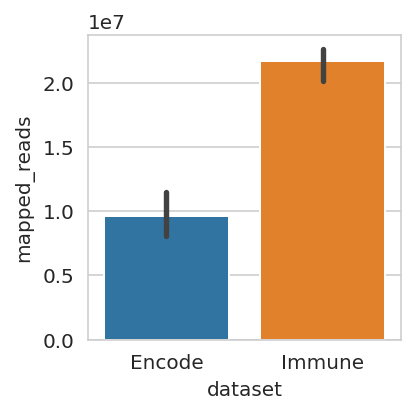

In [68]:
plt.figure(figsize=(3, 3))
ax = plt.axes()
g_results = sns.barplot(data=t[t['tool']=='MACS2'], x='dataset', y='mapped_reads', ax=ax)
plt.tight_layout()
plt.show()

In [69]:
# Ignore outliers
t = t[t['peaks_rpkm'] < 10000]
t = t[t['peaks_control_log2fc'] < 10]

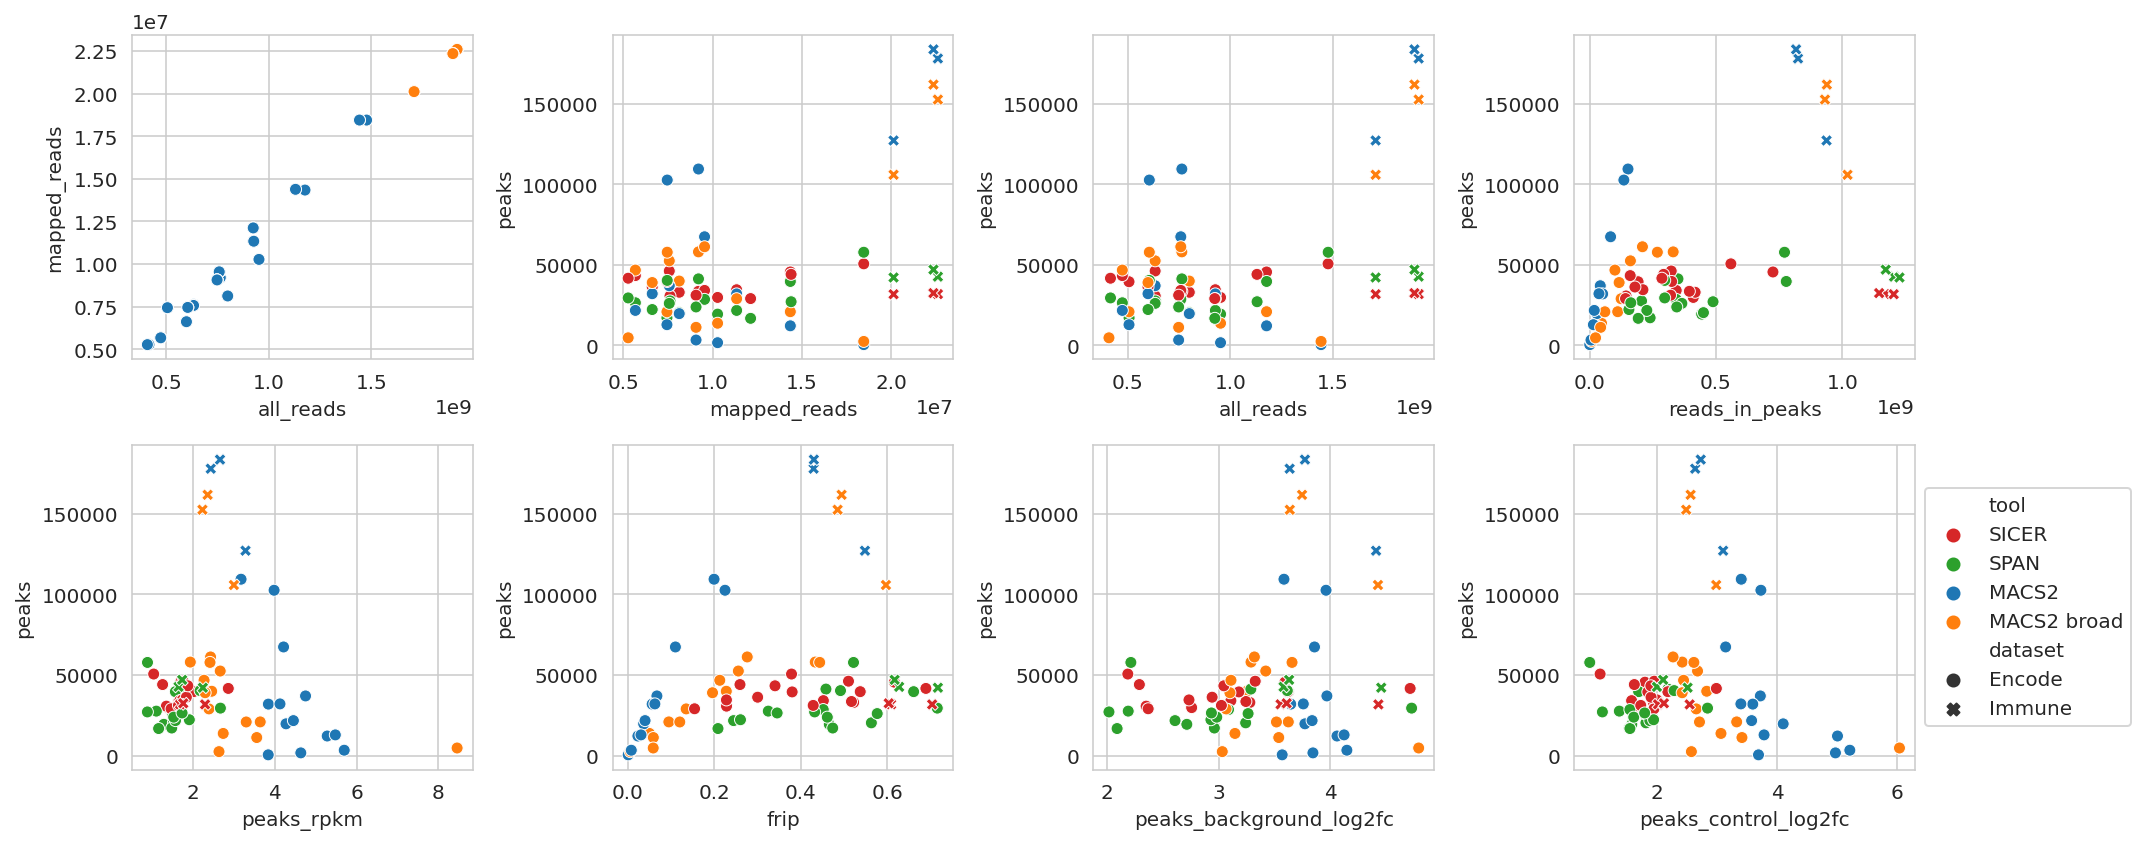

In [70]:
import seaborn as sns

plt.figure(figsize=(15, 6))
axs = [plt.subplot(2, 4, i + 1) for i in range(8)]
ax = axs[0]
g_results = sns.scatterplot(data=t, x='all_reads', y='mapped_reads', hue='dataset', ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[1]
g_results = sns.scatterplot(data=t, x='mapped_reads', y='peaks', hue='tool', style='dataset',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[2]
g_results = sns.scatterplot(data=t, x='all_reads', y='peaks', hue='tool', style='dataset',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[3]
g_results = sns.scatterplot(data=t, x='reads_in_peaks', y='peaks', hue='tool', style='dataset',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[4]
g_results = sns.scatterplot(data=t, x='peaks_rpkm', y='peaks', hue='tool', style='dataset',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[5]
g_results = sns.scatterplot(data=t, x='frip', y='peaks', hue='tool', style='dataset',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[6]
g_results = sns.scatterplot(data=t, x='peaks_background_log2fc', y='peaks', hue='tool', style='dataset',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[7]
g_results = sns.scatterplot(data=t, x='peaks_control_log2fc', y='peaks', hue='tool', style='dataset',
                            palette=TOOLS_PALETTE, ax=ax)
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.tight_layout()
plt.show()

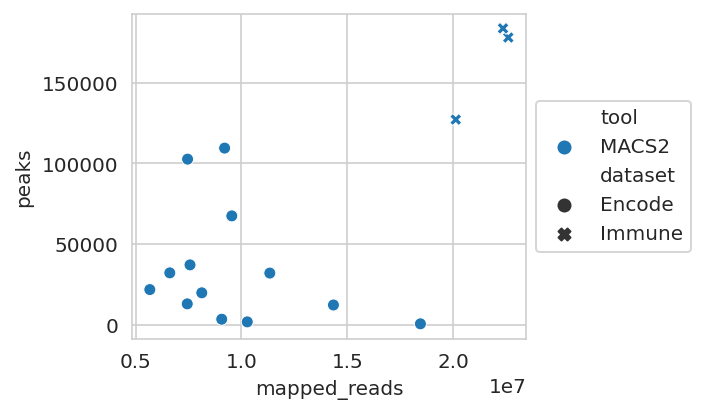

In [71]:
plt.figure(figsize=(5, 3))
ax = plt.axes()
g_results = sns.scatterplot(data=t[t['tool']=='MACS2'], x='mapped_reads', y='peaks', hue='tool', style='dataset',
                            palette=TOOLS_PALETTE, ax=ax)
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

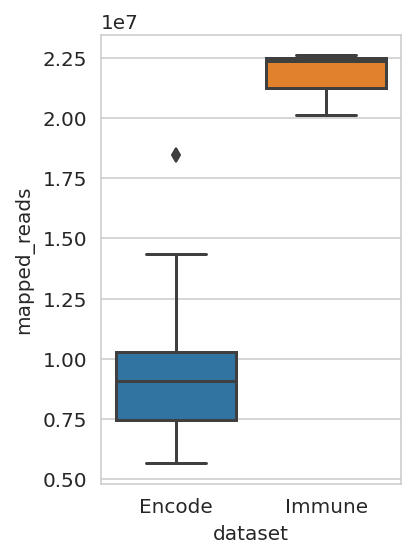

In [72]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
g_results = sns.boxplot(data=t[t['tool']=='MACS2'], y='mapped_reads', x='dataset', ax=ax)
plt.tight_layout()
plt.show()

Explained variation 93 %


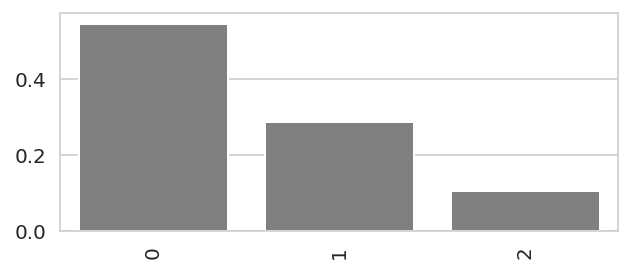

In [73]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import plotly.express as px

# t = t[(t['tool'].isin(['MACS2', 'MACS2 broad']))]

# Remove peaks and length features
features = [c for c in t.columns
            if c not in ['cell', 'replicate', 'bw_file', 'bw_control_file', 'tool', 'peaks_file', 'bam_file', 'modification', 'dataset',
                         'peaks', 'length']]

n_components = 3
pca = PCA(n_components=n_components)
ts = StandardScaler().fit_transform(t[features])  # (n_samples x n_features)
result_pca = pca.fit_transform(ts)

td = pd.DataFrame({'pc1': result_pca[:, 0], 'pc2': result_pca[:, 1],
                   'dataset': t['dataset'], 'tool': t['tool']})

fig = px.scatter(td, x='pc1', y='pc2', color='dataset',
                 hover_data=['dataset', 'tool'])
fig.layout.template = 'plotly_white'
fig.update_layout(
    autosize=False,
    width=800,
    height=600, )
fig.show()

print('Explained variation', int(np.sum(pca.explained_variance_ratio_) * 100), '%')
plt.figure(figsize=(5, 2))
g = sns.barplot(x=list(range(n_components)), y=pca.explained_variance_ratio_, color='gray')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

fig = go.Figure(data=go.Heatmap(
    z=pca.components_,
    y=[f'Component {i + 1}' for i in range(n_components)],
    x=features,
    colorscale='RdBu'
))
fig.layout.template = 'plotly_white'
fig.update_layout(
    autosize=False,
    width=600,
    height=600, )
fig.show()

# ChromHMM

In [74]:
CHROMHMM_MAP = {
    'GM12878': GSE26320_PATH_HG38 + '/chromhmm/GM12878_chromhmm_hg38_ENCFF338RIC.bed',
    'H1': GSE26320_PATH_HG38 + '/chromhmm/H1_chromhmm_hg38_ENCFF323HNB.bed',
    'HepG2': GSE26320_PATH_HG38 + '/chromhmm/HepG2_chromhmm_hg38_ENCFF808IZE.bed',
    'K562': GSE26320_PATH_HG38 + '/chromhmm/K562_chromhmm_hg38_ENCFF649FCE.bed',
}

print('Split chromHMM into separate files')
CHROMM_STATES = set()
for c, chromhmm in CHROMHMM_MAP.items():
    print(c)
    t = pd.read_csv(chromhmm, sep='\t', header=None, usecols=[3])[3]
    for state in t.unique():
        # print(state)
        state = state.replace('/', '_')
        CHROMM_STATES.add(state)
        f = chromhmm.replace('.bed', f'_{state}.bed')
        ! cat {chromhmm} | grep {state} > {f}
CHROMM_STATES = list(sorted(CHROMM_STATES))
print(CHROMM_STATES)

Split chromHMM into separate files
GM12878
H1
HepG2
K562
['EnhA1', 'EnhA2', 'EnhBiv', 'EnhG1', 'EnhG2', 'EnhWk', 'Het', 'Quies', 'ReprPC', 'ReprPCWk', 'TssA', 'TssBiv', 'TssFlnk', 'TssFlnkD', 'TssFlnkU', 'Tx', 'TxWk', 'ZNF_Rpts']


In [75]:
import tempfile
from itertools import product

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

data = []

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    if c not in CHROMHMM_MAP:
        continue
    chromhmm = CHROMHMM_MAP[c]
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        row = [c, r, tool, peaks]
        for state in CHROMM_STATES:
            state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
            !bedtools intersect -a {peaks_file} -b {state_file} -wa -u > {tf}
            state_peaks = lines(tf)
            row.append(state_peaks)
        data.append(row)

        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            row = [c, r, name, peaks]
            for state in CHROMM_STATES:
                state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
                !bedtools intersect -a {tf} -b {state_file} -wa -u > {tf2}
                state_peaks = lines(tf2)
                row.append(state_peaks)
            data.append(row)

chromhmm_df = pd.DataFrame(data, columns=['cell', 'replicate', 'name', 'peaks'] + CHROMM_STATES)
chromhmm_df

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


cell replicate                name  peaks  EnhA1  EnhA2  EnhBiv  EnhG1  \
0   GM12878      rep1               SICER  29804   5016   2956       2   5657   
1   GM12878      rep1                SPAN  19448   4128   2714       1   4460   
2   GM12878      rep1               MACS2   1741     16      2       0    217   
3   GM12878      rep1         MACS2 broad  13794    195     80       0   1843   
4   GM12878      rep1        SPAN - MACS2  18315   3645   2340       1   3679   
..      ...       ...                 ...    ...    ...    ...     ...    ...   
75    HepG2      rep2        MACS2 - SPAN      0      0      0       0      0   
76    HepG2      rep2  SPAN - MACS2 broad  27186   2184    494       3   6172   
77    HepG2      rep2  MACS2 broad - SPAN      0      0      0       0      0   
78    HepG2      rep2        SPAN - SICER   3888    170     28       1    183   
79    HepG2      rep2        SICER - SPAN    764     38      6       0     21   

    EnhG2  EnhWk  ...  ReprPC  ReprPCWk  TssA  TssBiv  TssFlnk  TssFlnkD  \
0    1449   9959  ...      78        75  3764       2     6665      3834   
1    1245   8327  ...      89        88  2845       3     6004      3759   
2      84      6  ...       0         0    25       0       69        30   
3     528    269  ...       0         0   176       0      551       292   
4     909   7632  ...      85        84  2230       3     5103      3133   
..    ...    ...  ...     ...       ...   ...     ...      ...       ...   
75      0      0  ...       0         0     0       0        0         0   
76   1268   6873  ...      34        31   366       3     1497      1071   
77      0      0  ...       0         0     0       0        0         0   
78     18    642  ...       5         5    20       1       76        46   
79      4    166  ...       2         2     8       0       23        16   

    TssFlnkU     Tx   TxWk  ZNF_Rpts  
0       2690  26196  25453         0  
1       2451  15779  15475         0  
2          9   1293     68         0  
3         96  12111   3105         0  
4       2038  14690  14413         0  
..       ...    ...    ...       ...  
75         0      0      0         0  
76       686  24794  23295         0  
77         0      0      0         0  
78        38   3147   2992         0  
79        14    614    610         0  

[80 rows x 22 columns]

In [76]:
chromhmm_df_mean = chromhmm_df[['name'] + CHROMM_STATES].groupby('name').mean()
chromhmm_df_mean = chromhmm_df_mean.loc[['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                         'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                         'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                         ]]
chromhmm_df_mean

EnhA1     EnhA2   EnhBiv     EnhG1     EnhG2     EnhWk  \
name                                                                            
MACS2                270.125    64.750   16.625  1645.750   662.625   496.375   
MACS2 broad          901.500   287.625   36.500  2984.875   892.375  1883.875   
SPAN                3033.750  1560.250  100.625  4537.625  1328.250  6665.500   
SICER               3325.625  1513.375   96.125  5487.750  1486.250  7474.500   
SPAN - MACS2        1994.875   989.500   60.750  2612.000   594.750  4730.625   
SPAN - MACS2 broad  1335.750   634.000   41.250  1637.000   348.000  3317.875   
SPAN - SICER         293.875   126.500   12.375   113.625    17.250   752.750   
MACS2 - SPAN           1.875     0.500    0.375     3.375     0.500     6.125   
MACS2 broad - SPAN    28.750     7.875    3.375    53.375     5.750   109.625   
SICER - SPAN          72.000    30.000    5.125    66.750     8.875   254.250   

                         Het     Quies   ReprPC  ReprPCWk      TssA   TssBiv  \
name                                                                           
MACS2                 55.125   795.875   39.000    19.250   105.625   14.500   
MACS2 broad          265.125  2010.875   83.875    51.625   303.375   34.000   
SPAN                1340.750  4514.750  202.875   158.000  1615.875  101.125   
SICER               1323.875  4721.375  194.000   146.750  2056.125  108.375   
SPAN - MACS2        1048.750  3657.000  148.000   116.750   726.000   56.000   
SPAN - MACS2 broad   750.375  2809.500  112.250    90.500   388.500   33.750   
SPAN - SICER         222.000  1186.000   44.875    36.375    52.875    8.875   
MACS2 - SPAN           1.625    32.750    2.000     1.000     0.125    0.125   
MACS2 broad - SPAN    17.500   326.625   18.750    13.750     5.750    1.625   
SICER - SPAN          44.000   325.500   18.250    15.125    24.750    3.750   

                     TssFlnk  TssFlnkD  TssFlnkU         Tx       TxWk  \
name                                                                     
MACS2                392.750   171.750   196.750  16344.625   2833.375   
MACS2 broad         1118.375   600.250   567.750  22608.250  11235.125   
SPAN                3854.000  2380.125  2104.500  18633.250  16918.125   
SICER               4298.250  2504.875  2367.625  30635.750  25836.375   
SPAN - MACS2        2099.375  1244.125  1009.250  13802.375  12706.625   
SPAN - MACS2 broad  1252.500   722.625   582.750   9735.250   9164.750   
SPAN - SICER         202.000   100.875   107.000   2193.000   2044.125   
MACS2 - SPAN           3.125     1.250     2.000     57.125     34.125   
MACS2 broad - SPAN    29.000    14.375    15.375    855.250    612.000   
SICER - SPAN          68.875    38.875    35.000    945.125    863.375   

                    ZNF_Rpts  
name                          
MACS2                    0.0  
MACS2 broad              0.0  
SPAN                     0.0  
SICER                    0.0  
SPAN - MACS2             0.0  
SPAN - MACS2 broad       0.0  
SPAN - SICER             0.0  
MACS2 - SPAN             0.0  
MACS2 broad - SPAN       0.0  
SICER - SPAN             0.0

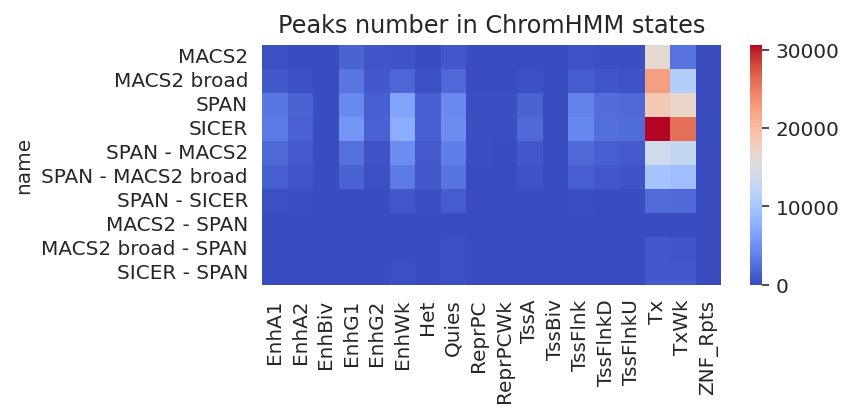

In [77]:
plt.figure(figsize=(6, 3))
sns.heatmap(chromhmm_df_mean, cmap='coolwarm')
plt.title('Peaks number in ChromHMM states')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K36me3_chromhmm.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [78]:
chromhmm_rel_df = chromhmm_df[['name']].copy()
for state in CHROMM_STATES:
    chromhmm_rel_df[state] = [d(ov, p) for ov, p in zip(chromhmm_df[state], chromhmm_df['peaks'])]
chromhmm_rel_df_mean = chromhmm_rel_df[['name'] + CHROMM_STATES].groupby('name').mean()
chromhmm_rel_df_mean = chromhmm_rel_df_mean.loc[['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                                 'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                                 'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                                 ]]
chromhmm_rel_df_mean

EnhA1     EnhA2    EnhBiv     EnhG1     EnhG2  \
name                                                                   
MACS2               0.007974  0.001924  0.000382  0.089783  0.033353   
MACS2 broad         0.021448  0.007190  0.000743  0.104539  0.031884   
SPAN                0.137949  0.074821  0.004572  0.198414  0.058284   
SICER               0.094659  0.044986  0.002726  0.150853  0.040743   
SPAN - MACS2        0.117749  0.060475  0.004285  0.136935  0.031539   
SPAN - MACS2 broad  0.110575  0.051288  0.004276  0.101122  0.021220   
SPAN - SICER        0.078349  0.034177  0.003187  0.033954  0.005171   
MACS2 - SPAN        0.004185  0.000842  0.000631  0.075167  0.064159   
MACS2 broad - SPAN  0.006055  0.001931  0.001000  0.041384  0.063625   
SICER - SPAN        0.073118  0.033861  0.005484  0.026110  0.004243   

                       EnhWk       Het     Quies    ReprPC  ReprPCWk  \
name                                                                   
MACS2               0.012809  0.001500  0.017337  0.000936  0.000462   
MACS2 broad         0.044354  0.006476  0.042514  0.001762  0.001053   
SPAN                0.299877  0.065543  0.210261  0.009408  0.007343   
SICER               0.210477  0.040016  0.134010  0.005536  0.004191   
SPAN - MACS2        0.272363  0.065336  0.237742  0.010016  0.007849   
SPAN - MACS2 broad  0.265139  0.064127  0.267224  0.011151  0.008945   
SPAN - SICER        0.206327  0.057668  0.306143  0.012236  0.009827   
MACS2 - SPAN        0.020922  0.010936  0.069490  0.007810  0.006126   
MACS2 broad - SPAN  0.040465  0.007261  0.112964  0.005962  0.004369   
SICER - SPAN        0.220796  0.065982  0.375943  0.015618  0.013083   

                        TssA    TssBiv   TssFlnk  TssFlnkD  TssFlnkU  \
name                                                                   
MACS2               0.005781  0.000366  0.017721  0.008094  0.006078   
MACS2 broad         0.008784  0.000749  0.030729  0.016640  0.013964   
SPAN                0.076149  0.004568  0.179911  0.110992  0.096297   
SICER               0.059963  0.003055  0.124090  0.072031  0.066937   
SPAN - MACS2        0.043349  0.003984  0.125813  0.073373  0.061983   
SPAN - MACS2 broad  0.031384  0.003595  0.100915  0.056346  0.050086   
SPAN - SICER        0.013874  0.002197  0.053432  0.027222  0.027802   
MACS2 - SPAN        0.000210  0.000210  0.006632  0.002790  0.004052   
MACS2 broad - SPAN  0.001522  0.000386  0.007070  0.003146  0.003310   
SICER - SPAN        0.019319  0.003289  0.061407  0.030791  0.032652   

                          Tx      TxWk  ZNF_Rpts  
name                                              
MACS2               0.723550  0.086694       0.0  
MACS2 broad         0.753536  0.294451       0.0  
SPAN                0.825940  0.754331       0.0  
SICER               0.860381  0.727380       0.0  
SPAN - MACS2        0.780922  0.718522       0.0  
SPAN - MACS2 broad  0.730156  0.685381       0.0  
SPAN - SICER        0.644144  0.597480       0.0  
MACS2 - SPAN        0.234731  0.148417       0.0  
MACS2 broad - SPAN  0.296051  0.239446       0.0  
SICER - SPAN        0.590998  0.564489       0.0

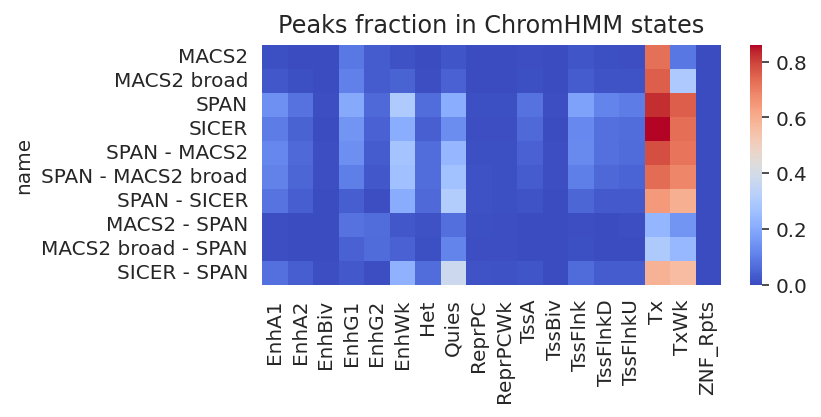

In [79]:
plt.figure(figsize=(6, 3))
sns.heatmap(chromhmm_rel_df_mean, cmap='coolwarm')
plt.title('Peaks fraction in ChromHMM states')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K36me3_chromhmm_rel.pdf', bbox_inches='tight', dpi=300)
plt.show()